# import stuff and define functions

In [1]:
# true if working from tbi, false is working from home
tbi = True

if tbi:
    base_folder = '/scr/aldea/kgutenbrunner/github/MA/'
else:
    base_folder = '/Users/katringutenbrunner/Desktop/MA/github/MA/'

## importing

In [2]:
import os
import csv
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from Bio import AlignIO, SeqIO
import varnaapi
import logomaker

import RNA

## functions

In [3]:
# remove gaps from target structure to get structure based on sequence
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

# get target frequency, based on target structure
def target_frequency(sequence, structure):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(structure)

# get length of sequence
def get_length(seq):
    return len(seq.replace('-', ''))

# check if the positions in the sequnces is a possible base pair
possible_pairs = [('A', 'U'), ('C', 'G'), ('G', 'C'), ('G', 'U'), ('U', 'A'), ('U', 'G')]
def check_bp(seq, position):
    if (seq[position[0]], seq[position[1]]) in possible_pairs:
        return True
    else:
        return False
    

In [4]:
# get mfe and mfe structure from sequence
def get_mfe(sequence):
    fc = RNA.fold_compound(sequence)
    fc.pf()
    (ss, mfe) = fc.mfe()
    return ss, mfe

# remove gaps from sequence and get mfe and mfe structure
def get_mfe_w_gaps(sequence):
    fc = RNA.fold_compound(sequence.replace('-', ''))
    fc.pf()
    (ss, mfe) = fc.mfe()
    return add_gaps(sequence, ss)

# add gaps back into the structure from a sequence with gaps
def add_gaps(sequence, structure):
    structure = list(structure)
    new_ss = [structure.pop(0) if nt != '-' else '-' for  nt in sequence]
    return ''.join(new_ss)

# convert dotbracket ss into a matrix
def db_to_matrix(db):
    matrix = np.zeros((len(db), len(db)), dtype=int)
    db_dict = {')': '(',
               ']': '[',
               '}': '{',
               '>': '<',
               'a': 'A'}
    db_stacks = {'(':[],
               '[':[],
               '{':[],
               '<':[],
               'A': []
               }

    for i, symbol in enumerate(db):
        if symbol in db_stacks.keys():
            db_stacks[symbol].append(i)
        elif symbol in ')}]>a':
            opening_index = db_stacks[db_dict[symbol]].pop()
            closing_index = i
            matrix[opening_index][closing_index] = 1
            matrix[closing_index][opening_index] = 1
    if any(db_stacks.values()):
        print(db)
        print(db_stacks)
        raise ValueError(f"structure {db} not balanced ")
    return matrix


# get base pairing heatmap of a matrix of base pair probabilities
def bp_plot(bp_matrix, title='MFE probability', folder = False):
    fig, ax = plt.subplots()
    cimg = ax.imshow(bp_matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax.set_xticks(np.arange(0, bp_matrix.shape[1], 5), np.arange(0, bp_matrix.shape[1], 5))
    ax.set_yticks(np.arange(0, bp_matrix.shape[0], 5), np.arange(0, bp_matrix.shape[0], 5))
    ax.set_title(title)
    ax.grid(color='gray', linestyle='--', linewidth=0.4)
    cbar = plt.colorbar(cimg, ax=ax)

    cbar_ax = cbar.ax  # Access the color bar's axes
    max_value = np.max(bp_matrix)
    cbar_ax.axhline(y=max_value, color='red', linestyle='--')  # Add a horizontal line
    

    if folder:
        plt.savefig(folder)
        plt.clf()
    else:
        plt.show()
        plt.clf()

In [5]:
# function for correlation analysis
def correlation_analysis(df, method = 'spearman', statistic_file = False, save_fig = False, labels = None, mask = True):
    stats_df = df.drop(columns='name').astype(int)
    
    #create some correlation analysis
    corr =  stats_df.corr(method=method, numeric_only=False)
    
    # Display the correlation matrix
    if mask:
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan

    if statistic_file:
        corr.to_csv(statistic_file)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1,)
    plt.colorbar(label=f'Correlation')
    plt.title(f'Correlation Heatmap by {method}')
    
    if labels:
        plt.xticks(np.arange(len(corr)), labels, rotation=45)
        plt.yticks(np.arange(len(corr)), labels)
    else:
        plt.xticks(np.arange(len(corr)), corr.columns, rotation=45)
        plt.yticks(np.arange(len(corr)), corr.columns)
        
    if save_fig:
        plt.savefig(save_fig)
    else:
        plt.show()
    return corr

In [6]:
def find_character(text, char):
    return [i for i, c in enumerate(text) if c == char]

def find_structure(ss):
    beta_indices = []
    gamma_indices = []       

    beta_stack = []
    gamma_stack = []

    beta = True
    for i in range(len(ss)):
        if ss[i] == '<':
            if beta:
                beta_stack.append(i)
                beta_indices.append(i)
            else:
                gamma_stack.append(i)
                gamma_indices.append(i)
        elif ss[i] == '>':
            if beta:
                beta_stack.pop()
                beta_indices.append(i)
            else:
                gamma_stack.pop()
                gamma_indices.append(i)
            if len(beta_stack) == 0:
                beta = False
    if beta_stack or gamma_stack:
        print('structure is wrong')
        raise ValueError


    alpha_indices = find_character(ss, '(') + find_character(ss, ')')

    return alpha_indices, beta_indices, gamma_indices

def get_length_of_structures(seq, ss):
    alpha_positions, beta_positions, gamma_positions = ss
    alpha_start, alpha_stop = alpha_positions[0], alpha_positions[-1] + 1
    beta_start, beta_stop = beta_positions[0], beta_positions[-1] + 1
    gamma_start, gamma_stop = gamma_positions[0], gamma_positions[-1] + 1


    alpha_stem = len([1 for pos in alpha_positions if seq[pos]!='-'])
    n = len(alpha_positions)
    hl_start, hl_stop = alpha_positions[int(n/2) -1] + 1, alpha_positions[int(n/2)]
    alpha = get_length(seq[alpha_start:hl_start]) + get_length(seq[hl_stop:alpha_stop])

    n = len(beta_positions)
    hl_start, hl_stop = beta_positions[int(n/2) -1] + 1, beta_positions[int(n/2)]
    beta = get_length(seq[beta_start:beta_stop])
    beta_hl = get_length(seq[hl_start:hl_stop])
    beta_stem = beta-beta_hl
    
    n = len(gamma_positions)
    hl_start, hl_stop = gamma_positions[int(n/2) -1] + 1, gamma_positions[int(n/2)]
    gamma = get_length(seq[gamma_start:gamma_stop])
    gamma_hl = get_length(seq[hl_start:hl_stop])
    gamma_stem = gamma-gamma_hl

    return alpha_stem, alpha, beta_stem, beta_hl, beta, gamma_stem, gamma_hl, gamma

In [7]:
def bp_between_regions(cons, ss):
    """Check if there are base pairs between two regions of consecutive dots in the predicted structure."""
    # Step 1: Identify the two regions of dots in `cons`
    regions = []
    start = None
    
    for i, char in enumerate(cons):
        if char == '.':
            if start is None:
                start = i  # Start of a dot region
        else:
            if start is not None:
                regions.append((start, i - 1))  # End of a dot region
                start = None
    
    if start is not None:
        regions.append((start, len(cons) - 1))  # Catch any trailing dot region
    
    if len(regions) < 2:
        raise ValueError("Not enough dot regions found in the constraint string.")
    
    first_region, second_region = regions[:2]

    # Step 2: Use a stack to find base pairs in the `ss` string and check if they connect the regions
    stack = []
    for i, char in enumerate(ss):
        if char == '(':
            stack.append(i)  # Push index onto stack for open parenthesis
        elif char == ')':
            if stack:
                j = stack.pop()  # Pop matching opening index
                # Check if one index is in the first region and the other in the second
                if (first_region[0] <= j <= first_region[1] and second_region[0] <= i <= second_region[1]) or \
                   (first_region[0] <= i <= first_region[1] and second_region[0] <= j <= second_region[1]):
                    return True  # Found a base pair connecting the two regions

    return False  # No connecting base pairs found

def count_bp_between_regions(cons, ss):
    # Step 1: Identify the two regions of dots in `cons`
    regions = []
    start = None
    
    for i, char in enumerate(cons):
        if char == '.':
            if start is None:
                start = i  # Start of a dot region
        else:
            if start is not None:
                regions.append((start, i - 1))  # End of a dot region
                start = None
    
    if start is not None:
        regions.append((start, len(cons) - 1))  # Catch any trailing dot region
    
    if len(regions) < 2:
        raise ValueError("Not enough dot regions found in the constraint string.")
    
    first_region, second_region = regions[:2]

    # Step 2: Use a stack to find base pairs in the `ss` string and count those connecting the regions
    stack = []
    bp_count = 0  # Initialize counter for base pairs between regions
    
    for i, char in enumerate(ss):
        if char == '(':
            stack.append(i)  # Push index onto stack for open parenthesis
        elif char == ')':
            if stack:
                j = stack.pop()  # Pop matching opening index
                # Check if one index is in the first region and the other in the second
                if (first_region[0] <= j <= first_region[1] and second_region[0] <= i <= second_region[1]) or \
                   (first_region[0] <= i <= first_region[1] and second_region[0] <= j <= second_region[1]):
                    bp_count += 1  # Increment counter

    return bp_count  # Return the total count of connecting base pairs




## colors for plots


In [8]:
MBFV_color = '#7a5195'
IR_color = '#bc5090'
CM_color = '#ffa600'

In [9]:
MBFV_color="#0072b2"
IR_color="#e69f00"
CM_color="#009e73"

# Mosquito Borne Flavi Virus Analysis

## import and clean up data

In [10]:
# get all the stk files except YFV
stk_folder = os.path.join(base_folder, 'data/mbfv_stk/')
stk_files = [os.path.join(stk_folder, file) for file in os.listdir(stk_folder) if file.endswith('xrRNA1.stk') and 'YFV' not in file]

In [11]:
# get the seqeuences from each stk file
sequences = []
rfs = []
for stk_file in stk_files:
    align = AlignIO.read(stk_file, "stockholm")
    rfs.append(align.column_annotations['reference_annotation'])
    for record in align:
        sequences.append(str(record.seq))

In [12]:
# used the stk files we used already in the MBFV analysis
MBFV_sequences = sequences

In [13]:
# import data from length counting file
# left YVf out since it has a really big hl beta --> outlier
MBFV_count_file = os.path.join(base_folder, 'xrRNA_design/analysis_MBFV/data/MBFV_xrRNA1.txt')
df = pd.read_csv(MBFV_count_file, delimiter=",")


In [14]:
# clean up data
# stems are counting as base pairs not nts
df = df.drop(columns=['seq_ML', 'seq_PKA', 'seq_PKB'])
# add stem structure together for further analysis
df_nts = df.copy()
temp_df = df_nts.drop(columns='name').astype(int)
df_nts['alpha'] = temp_df['stemA']*2
df_nts['beta'] = temp_df['stemB']*2 + temp_df['hlB']
df_nts['gamma'] = temp_df['stemG']*2 + temp_df['hlG']
df_nts['stemG'] = temp_df['stemG']*2
df_nts['stemB'] = temp_df['stemB']*2
df_nts['stemA'] = temp_df['stemA']*2

df_nts['n_PK'] = temp_df['n_PK']*2
# df_merge = df_merge[['name', 'I', 'II', 'III', 'HL', 'sum']]
new_order = ['name', 'stemA', 'alpha', 'stemB', 'hlB', 'beta', 'stemG','hlG','gamma', 'n_PK','bPK','b_PK','a_PK', 'len']

# save the df as unique dataframe for later use
df_MBFV = df_nts[new_order]

In [15]:
# deleter placeholder df
del df, df_nts, temp_df

## structure analysis

### boxplot of lengths

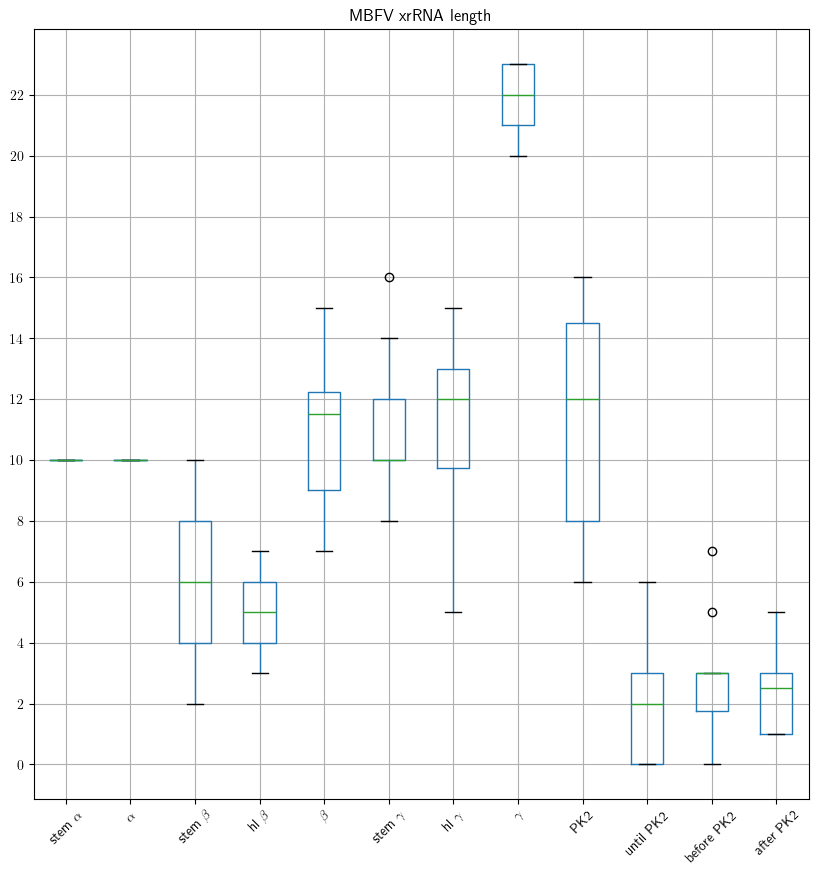

In [16]:
# create boxplot of different lengths
plt.rcParams['text.usetex'] = True

temp_df = df_MBFV.drop(columns=['name', 'len']).astype(int)
plt.figure(figsize=(10, 10))
temp_df.boxplot()
plt.title('MBFV xrRNA length')

labels = [r'stem $\alpha$', r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2', 'until PK2', 'before PK2', 'after PK2']
plt.xticks(list(range(1, len(labels)+1)), labels, rotation=45)
plt.yticks(np.arange(0, 24, step=2))
plt.show()
save_file = os.path.join(base_folder, 'thesis/images/MBFV_xrRNA_analysis_boxplot.png')
#plt.savefig(save_file)

### correlation analysis

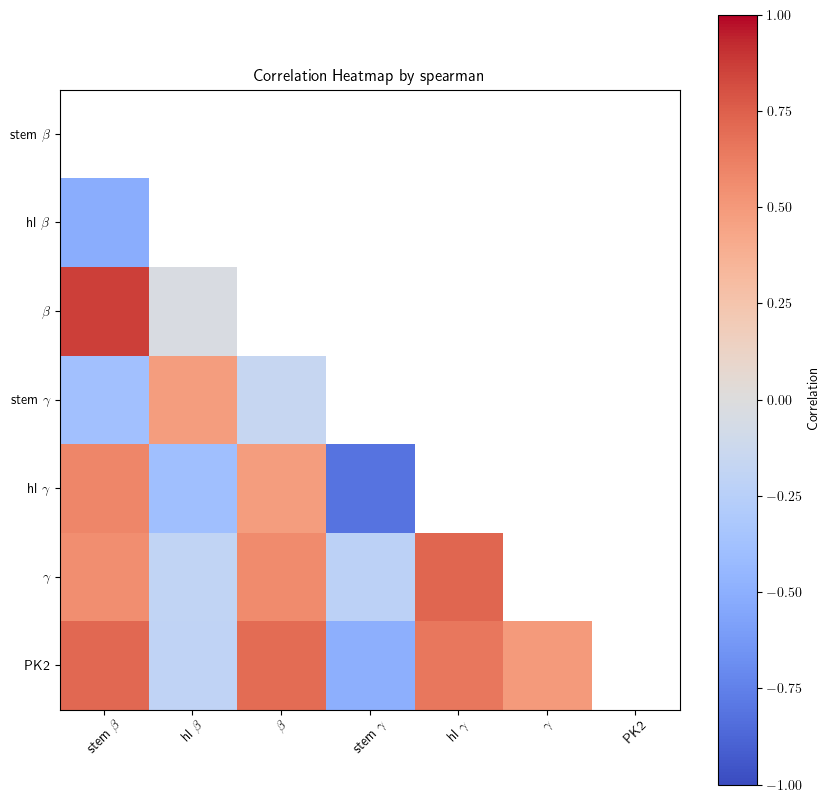

In [17]:
temp_df = df_MBFV.drop(columns=['stemA', 'alpha', 'bPK', 'a_PK', 'b_PK', 'len'])
labels = [r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2']

save_file = os.path.join(base_folder, 'thesis/images/MBFV_xrRNA_analysis_correlation.png')
correlation_analysis(temp_df, method="spearman", labels=labels, mask = True, save_fig=save_file)
del temp_df

### length distribution

Min: 50
Max: 62
Mean: 56.95


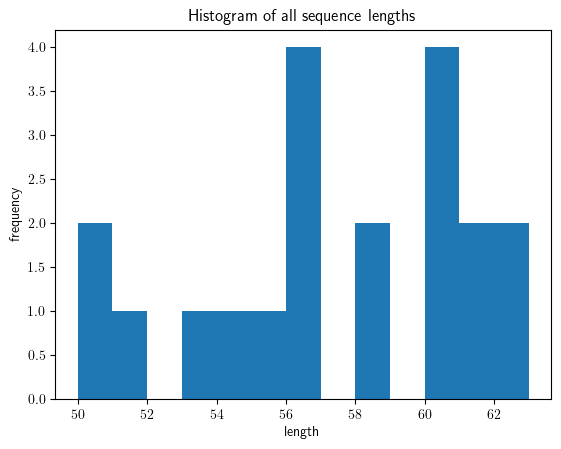

In [18]:
# plot the distributions of the lengths
sequence_lengths = [int(i) for i in list(df_MBFV['len'])]

# plot histogram of lengths
min_value = int(min(sequence_lengths))  # Minimum value in the data
max_value = int(max(sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(sequence_lengths, bins=bins)
plt.title('Histogram of all sequence lengths')
plt.xlabel('length')
plt.ylabel('frequency')

print('Min:', np.min(sequence_lengths))
print('Max:', np.max(sequence_lengths))
print('Mean:', round(np.mean(sequence_lengths),2))

In [19]:
MBFV_sequence_lengths = sequence_lengths

### MFE distribution

In [20]:
mfes = []
for sequence in MBFV_sequences:
    fc = RNA.fold_compound(sequence)
    fc.pf()
    (ss, mfe) = fc.mfe()
    mfes.append(mfe)
mfes = np.array(mfes)

Text(0, 0.5, 'frequency')

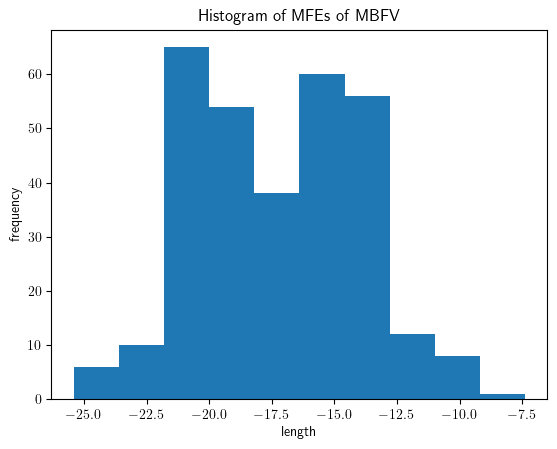

In [21]:
plt.hist(mfes)
plt.title('Histogram of MFEs of MBFV')
plt.xlabel('length')
plt.ylabel('frequency')

# Infrared

## load data

In [22]:
# load data into dataframe
seqs_file_ir = os.path.join(base_folder, 'thesis/data/MBFV_multiple_designs_wo_opt.csv')
df = pd.read_csv(seqs_file_ir, index_col=0)

In [23]:
# set target structure of infrared model
target_structures = [ '.....((((((((((.......))))).((((((((....................))))))))..)))))................',
        		      '..((............................................................)).....................',
        		      '...........................................((((((((..........................))))))))..']
target_ss =           '..[[.((((((((((.......))))).((((((((.......{{{{{{{{.....))))))))]])))))......}}}}}}}}..'

In [24]:
# get frequencies and the structures for each sequence
structures = []
frequencies = []
    
for i in range(len(df)):
    seq = df.iloc[i]['sequence']
    ss = remove_positioned_gaps(seq, target_structures[0])
    structures.append(ss)
    frequencies.append(target_frequency(seq, ss))



In [25]:
# create and save infrared df
df.insert(1, "structure", structures, True)
if tbi:
    df.insert(2, "frequency", frequencies, True)

df_IR = df
df_IR

,sequence,structure,frequency
0,AGUGUCAGGCC----CAAUAGG----GCUACG----GC-----GGC...,.....((((((.......).((((............))))..))))...,8.023358e-22
1,CUAGUCAGGCC----CGAUAA-----GCUACU----G------GGG...,.....((((((......).((((............))))..)))))...,2.798377e-12
2,CCAGUCAGGCCUG--UUA------UGGCUACC-----------GGC...,.....((((((((...))).((((............))))..))))...,1.168941e-17
3,GCUGUCAGGCC----UUGCU------GCCACCG---U------CGU...,.....((((((.....).(((((..........)))))..)))))....,8.097615e-10
4,UUAGUCAGGCCU---UGA-------GGCUACC----G------GGG...,.....(((((((...)).((((............))))..)))))....,1.028112e-18
...,...,...,...
995,UUUGUCAGGCCGU--GCAU-----AUGCUACGG----------GGU...,.....((((((((....))).(((((...........)))))..))...,9.454253e-12
996,AGUGUCAGGCCAA--CAC------UUGCUACU----CUA----GGC...,.....((((((((...))).((((............))))..))))...,3.525150e-20
997,CGUGUCAGGCC----CAAAUA-----GCUACG----A------CCG...,.....((((((......).((((..............))))..)))...,3.283095e-12
998,CUAGUCAGGCCC---AGAG------GGCCACG----AUCCA--UUG...,.....(((((((....)).((((...............))))..))...,3.261816e-16


## fast alignment based on target structure

In [26]:
# create a fasta file with designed sequence and target structure for a fast alignment
IR_seqs_strc_file = os.path.join(base_folder, 'thesis/data/seqs_struct_wo_optimization.fa')

with open(IR_seqs_strc_file, 'w') as f:
    for i in range(len(df_IR)):
        seq = df_IR.iloc[i]['sequence']
        ss = df_IR.iloc[i]['structure']
        f.write(f'>seq_{i}\n')
        f.write(seq.replace('-', ''))
        f.write('\n')
        f.write(f'{ss} #S') 
        f.write('\n')
        #print(df.iloc[i]['structure']) #.replace('-', '')

In [27]:
# create a fasta file with sequences
IR_seqs_file = os.path.join(base_folder, 'thesis/data/MBFV_sequences_wo_optimization.fa')
with open(IR_seqs_file, 'w') as f:
    for i in range(len(df_IR)):
        seq = df_IR.iloc[i]['sequence']
        f.write(f'>seq_{i}\n')
        f.write(seq)
        f.write('\n')
        #print(df.iloc[i]['structure']) #.replace('-', '')

In [28]:
# run RNAalifold to align the sequences
!RNAalifold {IR_seqs_file}

1000 sequences; length of alignment 87.
GCUGUCAGGCC____AAA________GCCACG___________GGGGGGGGG________GGUGCAGCCUG______CGCCGGCGUG
.......(((................)))..............((((((((..........................)))))))).. (-21.57 = -17.02 +  -4.55)


In [29]:
# manually get the consensus sequence from RNAalifold
IR_cons_seq = 'GCUGUCAGGCC____AAA________GCCACG___________GGGGGGGGG________GGUGCAGCCUG______CGCCGGCGUG'.replace('_', '-')

## Logo

Text(0, 0.5, 'Counts')

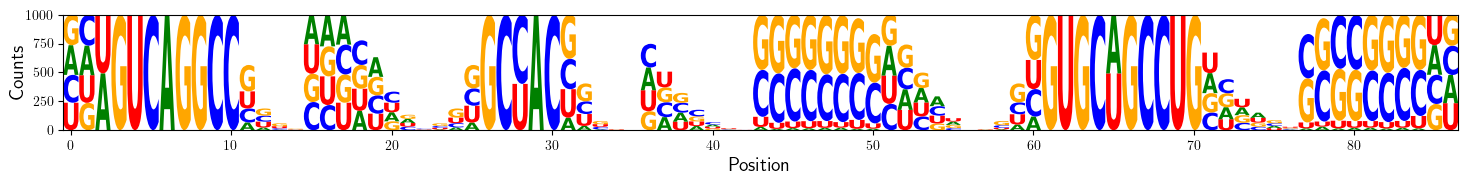

In [30]:
#Creating Counts Sequence Logo
alignment = AlignIO.read(IR_seqs_file, "fasta")

sequences = [str(record.seq) for record in alignment]
alignment_df = logomaker.alignment_to_matrix(sequences)

logo = logomaker.Logo(alignment_df, figsize=(18,1.5), color_scheme="classic")

logo.ax.set_xlabel('Position',fontsize=14)
logo.ax.set_ylabel("Counts", labelpad=-1,fontsize=14)

## shannon entropy

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUGUCAGGCC----AAA--------GCCACG-----------GGGGGGGGG--------GGUGCAGCCUG------CGCCGGCGUG', '-structureDBN', '..[[.((((((((((.......))))).((((((((.......{{{{{{{{.....))))))))]])))))......}}}}}}}}..', '-o', '/tmp/tmp2iyvif2x.png', '-baseNum', '#000000', '-resolution', '2.5', '-colorMap', '1.9986457703099174;1.9981330645231177;0.9998153271549207;-0.0;-0.0;-0.0;-0.0;-0.0;-0.0;-0.0;-0.0;2.047277949633706;1.0586128658905434;0.43405433758222906;0.1311702900368996;1.9996479528421043;1.9950029947661896;1.9990913835291497;2.3151202876428885;2.2113985394581968;1.5850296826168377;0.8357682093609105;0.13255711198481243;0.44086197653846637;1.0486657662215384;2.0640347504547742;-0.0;-0.0;0.9715325521731815;-0.0;-0.0;1.8821962217334858;1.726612318902518;0.5515265949219138;0.08986282119811381;-0.0;2.306614961835057;2.012208672265615;1.5527272240979315;1.02355202418024;0.5

Output file: /tmp/tmp2iyvif2x.png



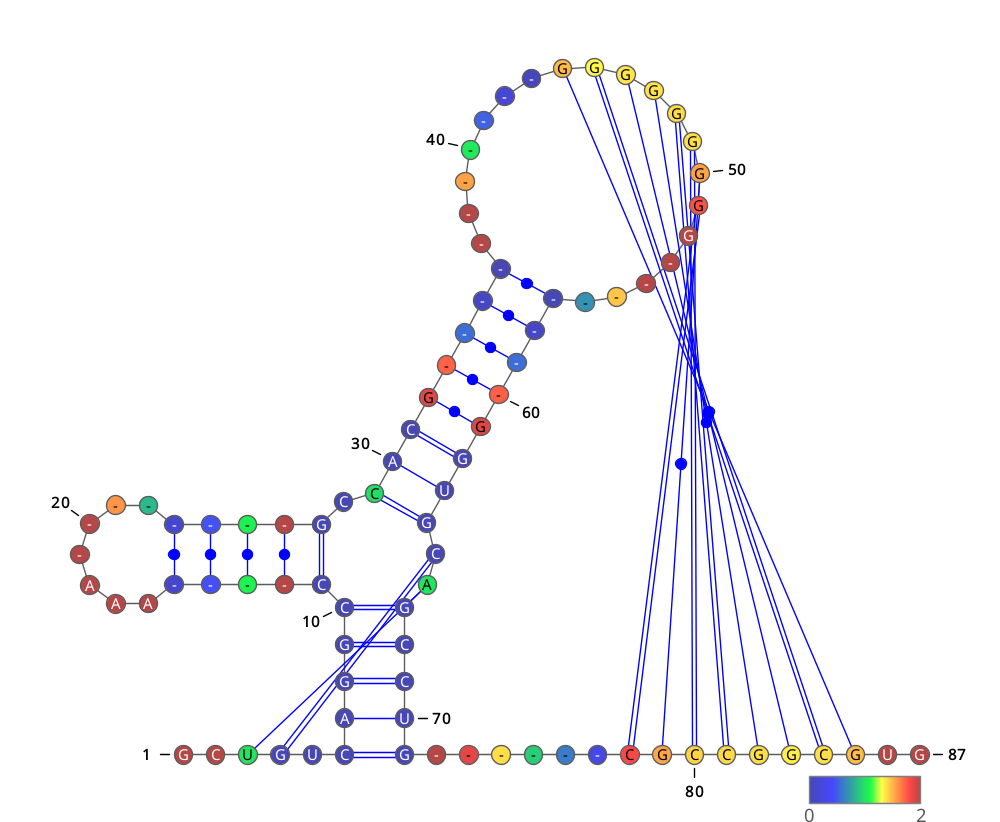

In [31]:
# calculate the shannon entropy for each position
alignment = AlignIO.read(IR_seqs_file, "fasta")
n = alignment.get_alignment_length()
N = len(alignment)

shannon_entropies = []
chars = list('ACGU')
for i in range(n):
    col = alignment[:, i].upper()
    unique_chars = set(col)
    frequencies = [ col.count(char)/N for char in unique_chars]
    shannon = - np.sum([freq * np.log2(freq) for freq in frequencies])
    shannon_entropies.append(shannon)

seq =      'WGUCAGGCCXXXXNNNXXXXXXXXGCYACNXXXXXXXXXXXNNNXXXXXNXXXXXXXXNGUGCWGCCUGXXXXXXXXXXXNNNNN'
cons_seq = IR_cons_seq
ss =  target_ss
v = varnaapi.Structure(sequence=cons_seq, structure=ss)


v.update(baseNum='black', drawBackbone=True, drawBases=True, fillBases=True, spaceBetweenBases=1, flat=True, resolution=2.5)
v.add_colormap(shannon_entropies, vMin=0, vMax=2, style='energy')

#v.flip(100)

v.show()
# v.savefig('/scr/aldea/kgutenbrunner/working/thesis/images/infrared_shannon_entropy.png')

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'WGUCAGGCCXXXXNNNXXXXXXXXGCYACNXXXXXXXXXXXNNNXXXXXNXXXXXXXXNGUGCWGCCUGXXXXXXXXXXXNNNNN', '-structureDBN', '..[[.((((((((((.......))))).((((((((.......{{{{{{{{.....))))))))]])))))......}}}}}}}}..', '-o', '/tmp/tmp60648vv1.png', '-baseNum', '#000000', '-resolution', '2.5', '-colorMap', '1.9986457703099174;1.9981330645231177;0.9998153271549207;-0.0;-0.0;-0.0;-0.0;-0.0;-0.0;-0.0;-0.0;2.047277949633706;1.0586128658905434;0.43405433758222906;0.1311702900368996;1.9996479528421043;1.9950029947661896;1.9990913835291497;2.3151202876428885;2.2113985394581968;1.5850296826168377;0.8357682093609105;0.13255711198481243;0.44086197653846637;1.0486657662215384;2.0640347504547742;-0.0;-0.0;0.9715325521731815;-0.0;-0.0;1.8821962217334858;1.726612318902518;0.5515265949219138;0.08986282119811381;-0.0;2.306614961835057;2.012208672265615;1.5527272240979315;1.02355202418024;0.504

Output file: /tmp/tmp60648vv1.png



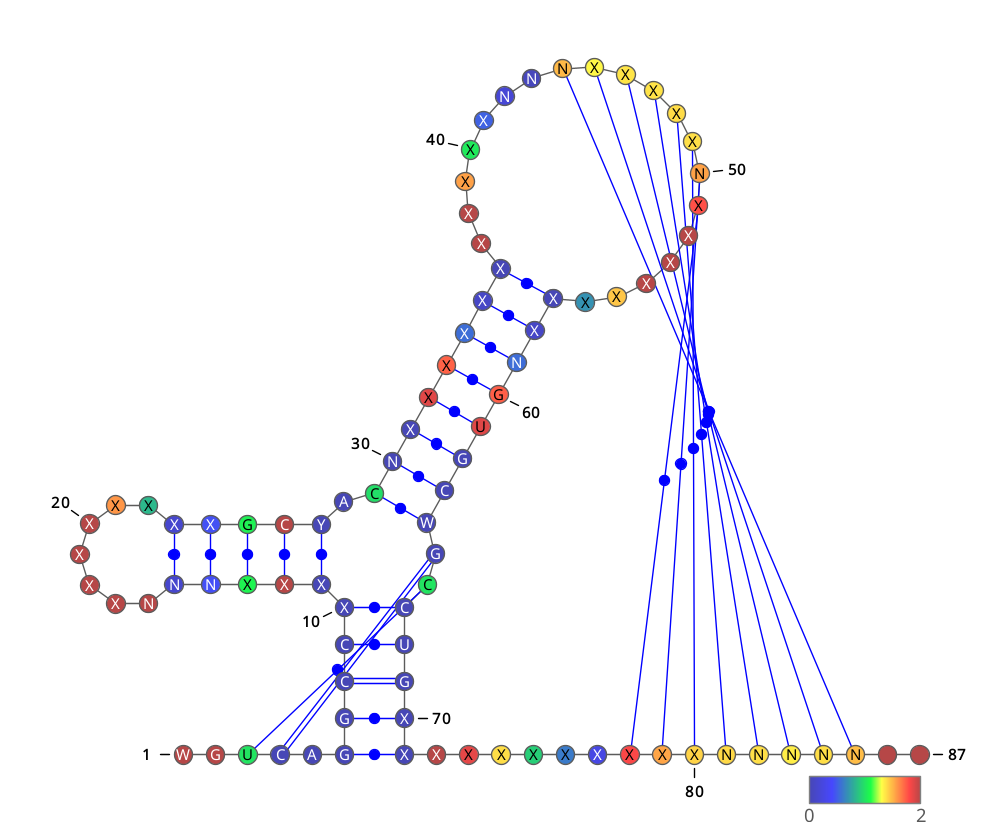

In [32]:
alignment = AlignIO.read(IR_seqs_file, "fasta")
n = alignment.get_alignment_length()
N = len(alignment)

shannon_entropies = []
chars = list('ACGU')
for i in range(n):
    col = alignment[:, i].upper()
    unique_chars = set(col)
    frequencies = [ col.count(char)/N for char in unique_chars]
    shannon = - np.sum([freq * np.log2(freq) for freq in frequencies])
    shannon_entropies.append(shannon)

seq =      'WGUCAGGCCXXXXNNNXXXXXXXXGCYACNXXXXXXXXXXXNNNXXXXXNXXXXXXXXNGUGCWGCCUGXXXXXXXXXXXNNNNN'
cons_seq = IR_cons_seq
ss =  target_ss
v = varnaapi.Structure(sequence=seq, structure=ss)


v.update(baseNum='black', drawBackbone=True, drawBases=True, fillBases=True, spaceBetweenBases=1, flat=True, resolution=2.5)
v.add_colormap(shannon_entropies, vMin=0, vMax=2, style='energy')

#v.flip(100)

v.show()


## base pairing heatmap

In [33]:
# calculate the mfe structure for each sequence and create a heatmap of it

bps = []

for i in range(len(df_IR)):
    seq = df_IR.iloc[i]['sequence']
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    BPP = fc.bpp()
    # Create the mirrored array
    mirrored_array = np.triu(BPP) + np.triu(BPP, 1).T
    bps.append(np.array(mirrored_array))

bps = np.sum(bps, axis=0)
bps /= N
IR_bps = bps


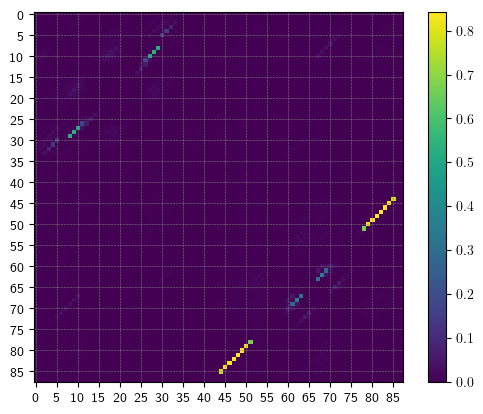

<Figure size 640x480 with 0 Axes>

In [34]:
# get base pairing heatmap of a matrix of base pair probabilities
fig, ax = plt.subplots()
cimg = ax.imshow(IR_bps, cmap='viridis', interpolation='nearest')
ax.set_xticks(np.arange(0, IR_bps.shape[1], 5), np.arange(0, IR_bps.shape[1], 5))
ax.set_yticks(np.arange(0, IR_bps.shape[0], 5), np.arange(0, IR_bps.shape[0], 5))
#ax.set_title(title)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
cbar = plt.colorbar(cimg, ax=ax)

cbar_ax = cbar.ax  # Access the color bar's axes
max_value = np.max(IR_bps)
cbar_ax.axhline(y=max_value, color='red', linestyle='--')  # Add a horizontal line

plt.show()
plt.clf()

In [35]:
# data with new weights
# calculate the mfe structure for each sequence and create a heatmap of it
# load data into dataframe
seqs_file_ir = os.path.join(base_folder, 'thesis/data/MBFV_multiple_designs_wo_opt_new.csv')
df_new_w = pd.read_csv(seqs_file_ir, index_col=0)
bps = []

for i in range(len(df_new_w)):
    seq = df_new_w.iloc[i]['sequence']
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    BPP = fc.bpp()
    # Create the mirrored array
    mirrored_array = np.triu(BPP) + np.triu(BPP, 1).T
    bps.append(np.array(mirrored_array))

bps = np.sum(bps, axis=0)
bps /= N
IR_new_w_bps = bps


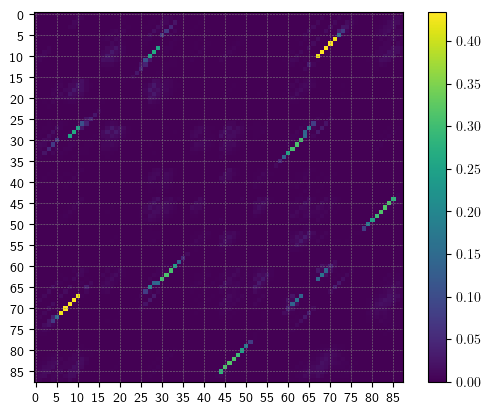

<Figure size 640x480 with 0 Axes>

In [36]:
# get base pairing heatmap of a matrix of base pair probabilities
fig, ax = plt.subplots()
cimg = ax.imshow(IR_new_w_bps, cmap='viridis', interpolation='nearest')
ax.set_xticks(np.arange(0, IR_new_w_bps.shape[1], 5), np.arange(0, IR_new_w_bps.shape[1], 5))
ax.set_yticks(np.arange(0, IR_new_w_bps.shape[0], 5), np.arange(0, IR_new_w_bps.shape[0], 5))
#ax.set_title(title)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
cbar = plt.colorbar(cimg, ax=ax)

cbar_ax = cbar.ax  # Access the color bar's axes
max_value = np.max(IR_new_w_bps)
cbar_ax.axhline(y=max_value, color='red', linestyle='--')  # Add a horizontal line

plt.show()
plt.clf()

## length distribution

In [37]:
# get lengths of each sequence
sequence_lengths = [get_length(df_IR.iloc[i]['sequence']) - 2 for i in range(len(df_IR))]

Text(0, 0.5, 'frequency')

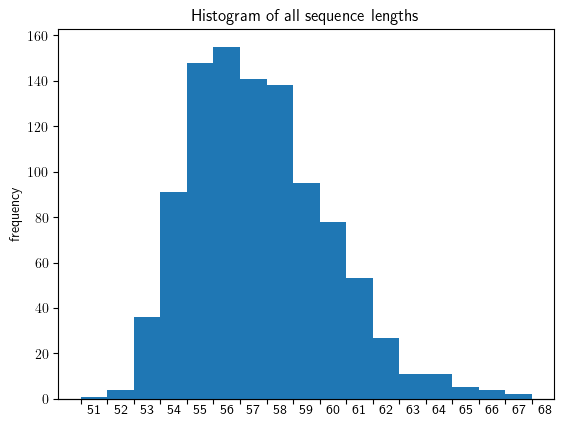

In [38]:
# plot histogram of lengths
# plot histogram of lengths
min_value = int(min(sequence_lengths))  # Minimum value in the data
max_value = int(max(sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin

fig, ax = plt.subplots()

ax.hist(sequence_lengths, bins=bins)
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax.set_xticks(bins, ['']*len(bins))
sec = ax.secondary_xaxis(location=0)
sec.set_xticks(bins+0.5, bins)
sec.tick_params('x', length=0)

ax.set_title('Histogram of all sequence lengths')
##ax.set_xlabel('length')
ax.set_ylabel('frequency')

In [39]:
IR_sequence_lengths = sequence_lengths

## boxplot of lengths

In [40]:
# get all the lengths of the different parts of the ss
alpha_lens =[]
beta_stem_lens =[]
beta_hl_lens =[]
beta_lens=[]
gamma_stem_lens =[]
gamma_hl_lens  = []
gamma_lens  = []
pk2_lens  = []
until_pk2_lens  = []
before_pk2_lens  = []
after_pk2_lens = []

In [41]:
# manually set the regions to get part lengths
IR_sequences = list(df_IR['sequence'])
for seq in IR_sequences:    
    alpha = get_length(seq[5:10]) * 2
    
    beta = get_length(seq[10:27])
    beta_hl = get_length(seq[15:22])
    beta_stem = beta-beta_hl


    gamma = get_length(seq[28:64] )
    gamma_hl = get_length(seq[36:56] )
    gamma_stem = gamma-gamma_hl

    pk2_len = get_length(seq[43:51]) * 2
    until_pk2 = get_length(seq[71:77])
    before_pk2 = get_length(seq[36:43])
    after_pk2 = get_length(seq[51:56])

    alpha_lens.append(alpha)
    beta_stem_lens.append(beta_stem)
    beta_hl_lens.append(beta_hl)
    beta_lens.append(beta)
    gamma_stem_lens.append(gamma_stem)
    gamma_hl_lens.append(gamma_hl)
    gamma_lens.append(gamma)
    pk2_lens.append(pk2_len)
    until_pk2_lens.append(until_pk2)
    before_pk2_lens.append(before_pk2)
    after_pk2_lens.append(after_pk2)

In [42]:
# create panda dataframe to save lengths
lens_dict = {
    'alpha_stems_lens': alpha_lens,
    'alpha_lens': alpha_lens,
    'beta_stem_lens': beta_stem_lens,
    'beta_hl_lens': beta_hl_lens,
    'beta_lens': beta_lens,
    'gamma_stem_lens': gamma_stem_lens,
    'gamma_hl_lens': gamma_hl_lens,
    'gamma_lens': gamma_lens,
    'pk2_lens': pk2_lens,
    'until_pk2_lens': until_pk2_lens,
    'before_pk2_lens': before_pk2_lens,
    'after_pk2_lens': after_pk2_lens
}
df_IR_lens = pd.DataFrame(lens_dict)

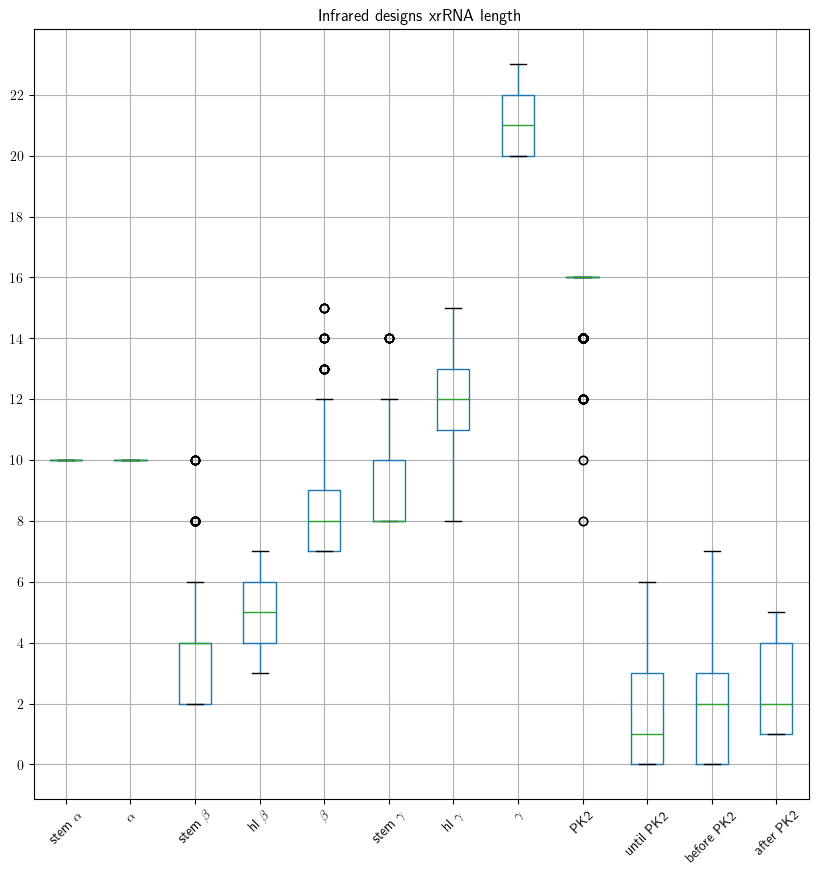

In [43]:
# create boxplot of different lengths

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 10))
df_IR_lens.boxplot()
plt.title('Infrared designs xrRNA length')

labels = [r'stem $\alpha$', r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2', 'until PK2', 'before PK2', 'after PK2']
plt.xticks(list(range(1, len(labels)+1)), labels, rotation=45)
plt.yticks(np.arange(0, 24, step=2))
plt.show()
# save_file = os.path.join(base_folder, 'thesis/images/xrRNA_analysis_boxplot.png')
# plt.savefig(save_file)

## Pseudo knots

In [44]:
pk1_ = find_structure(target_structures[1])[0]
pk1_bps = [(pk1_[0], pk1_[-1]), (pk1_[1], pk1_[-2])]

possible_PK2_region = find_structure(target_structures[2])[0]
hard_constraints_pk2 = ['.' if i in possible_PK2_region else 'x' for i in range(len(target_structures[0])) ]
hard_constraints_pk2 = ''.join(hard_constraints_pk2)

IR_pk1_counter =  0
IR_pk1_both = 0

IR_pk2_counter = 0
IR_pk2_bps = []

IR_both_pks = 0

In [45]:


for seq in IR_sequences:
    both_bps = 0
    for bp in pk1_bps:
        if check_bp(seq, bp):
            IR_pk1_counter+=1
            both_bps += 1
    if both_bps == 2:
        IR_pk1_both += 1

    # Create a fold compound with constraints
    constraints = remove_positioned_gaps(seq, hard_constraints_pk2)
    culled_seq = seq.replace('-', '')
    fc = RNA.fold_compound(culled_seq)

    # Apply the constraint
    fc.hc_add_from_db(constraints)

    # Compute the secondary structure with the constraint applied
    structure, mfe = fc.mfe()  # mfe() computes the Minimum Free Energy (MFE) secondary structure

    if mfe != 0:
        if bp_between_regions(constraints, structure):
            IR_pk2_counter += 1
            IR_pk2_bps.append(count_bp_between_regions(constraints, structure))
            if both_bps > 1:
                IR_both_pks += 1


IR_pk1_counter /= (len(IR_sequences) * len(pk1_bps))
IR_pk1_both /= len(IR_sequences)
IR_pk2_counter /= len(IR_sequences)
IR_both_pks /= len(IR_sequences)



print('PK1:\t\t\t', IR_pk1_counter)
print('mean # of PK2 bps:\t', IR_pk1_both)
        
print('\nPK2:\t\t\t', IR_pk2_counter)
print('mean # of PK2 bps:\t', round(np.mean(IR_pk2_bps), 2))



print('\nboth PKs:\t\t', IR_both_pks)


PK1:			 1.0
mean # of PK2 bps:	 1.0

PK2:			 1.0
mean # of PK2 bps:	 7.78

both PKs:		 1.0


In [46]:

find_structure(target_structures[1])[0]
IR_pk1_counter =  0
for seq in IR_sequences:
    for bp in pk1_bps:
        if check_bp(seq, bp):
            IR_pk1_counter+=1
            
IR_pk1_counter /= (len(IR_sequences) * len(pk1_bps))
IR_pk1_counter

1.0

## length distribution before and after optimization

In [47]:
csv_folder = os.path.join(base_folder, 'xrRNA_design/MBFV_design/data/seqs/before_after_opt/22_10_24')
csv_files = [os.path.join(csv_folder, file) for file in os.listdir(csv_folder) if file.endswith('csv')]


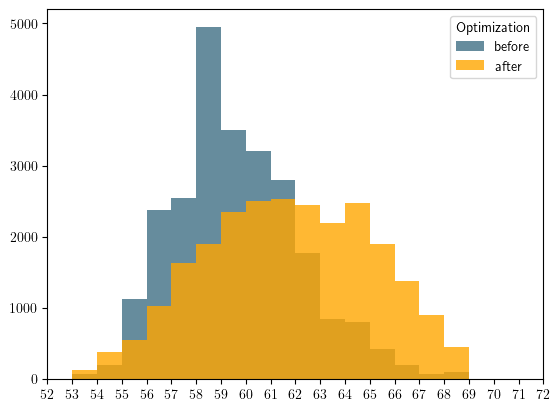

In [48]:
all_seqs = pd.DataFrame(columns=['before', 'after'])
for file in csv_files:
    df = pd.read_csv(csv_files[0])
    all_seqs = pd.concat([all_seqs, df], ignore_index=True)

df_lengths = pd.DataFrame(columns=['before', 'after'])

lengths_before = [len(i.replace('-', '')) for i in all_seqs['before']]
lengths_after = [len(i.replace('-', '')) for i in all_seqs['after']]
differences = [lengths_after[i] - lengths_before[i] for i in range(len(lengths_after))]

min_value = int(min(lengths_before))  # Minimum value in the data
max_value = int(max(lengths_before))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(lengths_before, bins = bins, alpha=0.6, color = '#003f5c')
plt.hist(lengths_after, bins =bins, alpha=0.8, color='#ffa600')
plt.xticks(list(range(52, 73)))
plt.legend(['before', 'after'], title='Optimization', frameon=True)

plt.show()



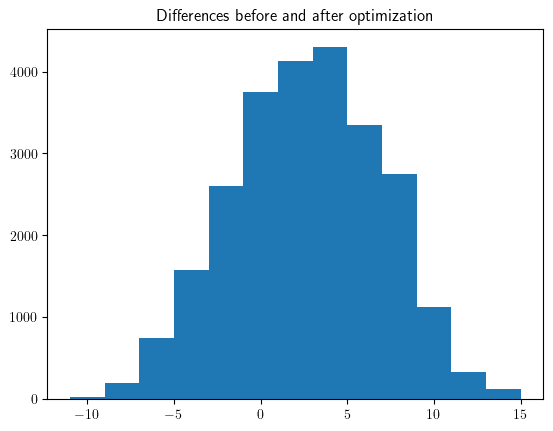

In [49]:
min_value = int(min(differences))  # Minimum value in the data
max_value = int(max(differences))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 2)  # +2 to include the last bin
plt.hist(differences, bins = bins, )
#plt.xticks(list(range(55, 73)))
plt.title('Differences before and after optimization')
plt.show()


### boxplot before and after opt

In [50]:
seq_before = [i.replace('-', '') for i in all_seqs['before']]
seq_after = [i.replace('-', '') for i in all_seqs['after']]

In [51]:
# get all the lengths of the different parts of the ss
alpha_lens =[]
beta_stem_lens =[]
beta_hl_lens =[]
beta_lens=[]
gamma_stem_lens =[]
gamma_hl_lens  = []
gamma_lens  = []
pk2_lens  = []
until_pk2_lens  = []
before_pk2_lens  = []
after_pk2_lens = []
# manually set the regions to get part lengths
for seq in seq_before:    
    alpha = get_length(seq[5:10]) * 2
    
    beta = get_length(seq[10:27])
    beta_hl = get_length(seq[15:22])
    beta_stem = beta-beta_hl


    gamma = get_length(seq[28:64] )
    gamma_hl = get_length(seq[36:56] )
    gamma_stem = gamma-gamma_hl

    pk2_len = get_length(seq[43:51]) * 2
    until_pk2 = get_length(seq[71:77])
    before_pk2 = get_length(seq[36:43])
    after_pk2 = get_length(seq[51:56])

    alpha_lens.append(alpha)
    beta_stem_lens.append(beta_stem)
    beta_hl_lens.append(beta_hl)
    beta_lens.append(beta)
    gamma_stem_lens.append(gamma_stem)
    gamma_hl_lens.append(gamma_hl)
    gamma_lens.append(gamma)
    pk2_lens.append(pk2_len)
    until_pk2_lens.append(until_pk2)
    before_pk2_lens.append(before_pk2)
    after_pk2_lens.append(after_pk2)

# create panda dataframe to save lengths
lens_dict = {
    'alpha_stems_lens': alpha_lens,
    'alpha_lens': alpha_lens,
    'beta_stem_lens': beta_stem_lens,
    'beta_hl_lens': beta_hl_lens,
    'beta_lens': beta_lens,
    'gamma_stem_lens': gamma_stem_lens,
    'gamma_hl_lens': gamma_hl_lens,
    'gamma_lens': gamma_lens,
    'pk2_lens': pk2_lens,
    'until_pk2_lens': until_pk2_lens,
    'before_pk2_lens': before_pk2_lens,
    'after_pk2_lens': after_pk2_lens
}
seq_before_lens = pd.DataFrame(lens_dict)

In [52]:
# get all the lengths of the different parts of the ss
alpha_lens =[]
beta_stem_lens =[]
beta_hl_lens =[]
beta_lens=[]
gamma_stem_lens =[]
gamma_hl_lens  = []
gamma_lens  = []
pk2_lens  = []
until_pk2_lens  = []
before_pk2_lens  = []
after_pk2_lens = []
# manually set the regions to get part lengths
for seq in seq_after:    
    alpha = get_length(seq[5:10]) * 2
    
    beta = get_length(seq[10:27])
    beta_hl = get_length(seq[15:22])
    beta_stem = beta-beta_hl


    gamma = get_length(seq[28:64] )
    gamma_hl = get_length(seq[36:56] )
    gamma_stem = gamma-gamma_hl

    pk2_len = get_length(seq[43:51]) * 2
    until_pk2 = get_length(seq[71:77])
    before_pk2 = get_length(seq[36:43])
    after_pk2 = get_length(seq[51:56])

    alpha_lens.append(alpha)
    beta_stem_lens.append(beta_stem)
    beta_hl_lens.append(beta_hl)
    beta_lens.append(beta)
    gamma_stem_lens.append(gamma_stem)
    gamma_hl_lens.append(gamma_hl)
    gamma_lens.append(gamma)
    pk2_lens.append(pk2_len)
    until_pk2_lens.append(until_pk2)
    before_pk2_lens.append(before_pk2)
    after_pk2_lens.append(after_pk2)

# create panda dataframe to save lengths
lens_dict = {
    'alpha_stems_lens': alpha_lens,
    'alpha_lens': alpha_lens,
    'beta_stem_lens': beta_stem_lens,
    'beta_hl_lens': beta_hl_lens,
    'beta_lens': beta_lens,
    'gamma_stem_lens': gamma_stem_lens,
    'gamma_hl_lens': gamma_hl_lens,
    'gamma_lens': gamma_lens,
    'pk2_lens': pk2_lens,
    'until_pk2_lens': until_pk2_lens,
    'before_pk2_lens': before_pk2_lens,
    'after_pk2_lens': after_pk2_lens
}
seq_after_lens = pd.DataFrame(lens_dict)

In [53]:
seq_before_lens['opt'] = 'before'
seq_after_lens['opt'] = 'after'
combined = pd.concat([seq_before_lens, seq_after_lens], ignore_index=True, sort=False)

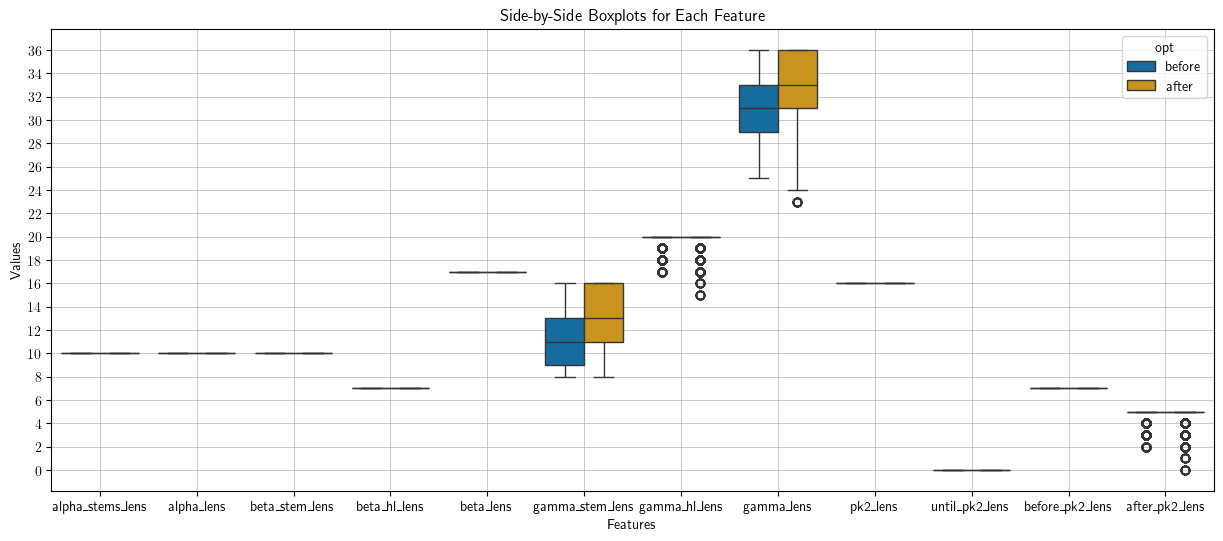

In [54]:
# Melt the DataFrame to have 'feature' as one column, and 'value' as another column
melted = pd.melt(combined, id_vars='opt', var_name='feature', value_name='value')

custom_palette = {
    'before': MBFV_color,
    'after': IR_color,
}

# Create the boxplot, showing features on the x-axis, and the values on the y-axis
plt.figure(figsize=(15, 6))
sns.boxplot(x='feature', y='value', hue='opt', data=melted, palette=custom_palette)

# Set title and labels
plt.title('Side-by-Side Boxplots for Each Feature')
plt.xlabel('Features')
plt.ylabel('Values')
#labels = [r'Stem $\alpha$', r'$\alpha$', r'Stem $\beta$', r'HL $\beta$', r'$\beta$', r'Stem $\gamma$', r'HL $\gamma$', r'$\gamma$', 'PK2', 'until PK2', 'before PK2', 'after PK2']
#plt.xticks(list(range(len(labels))), labels, rotation=45)

plt.grid(True, which='both', linestyle='-', linewidth=0.7, alpha=0.7)

max_value = melted['value'].max()  # Get the max value from the 'value' column
plt.yticks(np.arange(0, max_value + 1, 2))  # Adjust the step size here

# Display the plot
plt.show()


# Covariance Model

## create CM model


In [55]:
# used the stk files we used already in the MBFV analysis
stk_files_CM = stk_files

In [56]:
output_fa_CM = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/data/combined.fa')

In [57]:
# create and fasta file from all the sequences
with open(output_fa_CM, 'w') as f:
    for stk_file in stk_files_CM:
        align = AlignIO.read(stk_file, "stockholm")
        for record in align:
            
            f.write(f'>{record.id}\n')
            f.write(f'{record.seq}\n')
            f.write(f"{align.column_annotations['secondary_structure']} #S\n")

In [58]:
# use mlocarna to create a alignment file
# !mlocarna $output_fa_CM

In [59]:
# save the output consensus secondary structure from mlocarna
alifold = '...(((((((((.......)))).(((((.............)))))..)))))...............'

In [60]:
# create a stockholm file based on the mlocarna alignment

# get the alignment file
input_file = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/data/combined.out/results/result.aln')
# output name for the stockholm file
align_stk_file = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/data/alignment.stk')

input_file = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/stk_files/combined.out/results/result.aln')


# Load the Clustal alignment
alignment = AlignIO.read(input_file, "clustal")
# add the secondary structure from mlocarna manually
alignment.column_annotations["secondary_structure_cons"] = alifold
alignment.column_annotations['secondary_structure'] = alifold

# Write the alignment in Stockholm format
AlignIO.write(alignment, align_stk_file, "stockholm")

1

In [61]:
# create the covariance model based on the stockholm we just created
#!cmbuild /scr/aldea/kgutenbrunner/working/cov_model/MBFV_xrRNA1/MBFV_xrRNA1.cm $stk_file

## load data designs

In [62]:
# load the just create model
cm_model = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/MBFV_xrRNA1.cm')
designs_file_CM = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/data/designed_sequences.out')

In [63]:
# create 100 sequences from the model
# !cmemit -N 100 -a -o $designs_file $cm_model

In [64]:
align = AlignIO.read(designs_file_CM, "stockholm")

SS_cons = align.column_annotations['secondary_structure']
RF = align.column_annotations['reference_annotation']

## Logo Counts

Text(0, 0.5, 'Counts')

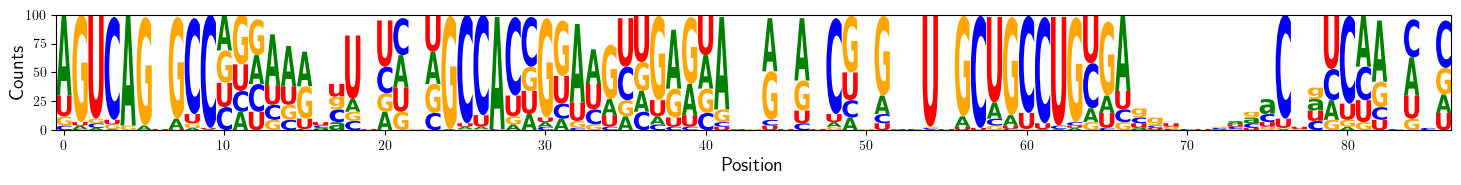

In [65]:
#Creating Counts Sequence Logo
alignment = AlignIO.read(designs_file_CM, "stockholm")

sequences = [str(record.seq) for record in alignment]
alignment_df = logomaker.alignment_to_matrix(sequences)

logo = logomaker.Logo(alignment_df, figsize=(18,1.5), color_scheme="classic")

logo.ax.set_xlabel('Position',fontsize=14)
logo.ax.set_ylabel("Counts", labelpad=-1,fontsize=14)

In [66]:
# plt.savefig('/scr/aldea/kgutenbrunner/working/cov_model/MBFV_xrRNA1/logo.pdf')


## shannon entropy

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'AGUCAG.GCCagcaAa..U.gc.uGCCACcGgAaguuGAGuA..a.A.Cg.G..U.GCUGCCUGuGA.........C..UCaA.c.c', '-structureDBN', ':::(((.((<<<<___.._.>>.>>,<<<<<___________.._._.>>.>..>.>,,))))):::.........:..::::.:.:', '-o', '/tmp/tmph7j4ndbn.png', '-baseNum', '#000000', '-resolution', '2.5', '-colorMap', '1.3583878143381718;0.467340745400986;0.7004534362146307;0.7004534362146307;0.3224933618603243;0.38254266919774566;0.08079313589591118;0.654263115244095;0.9650245867351425;0.16144054254182066;1.9752236776176522;1.8795565951000934;2.1267002859380346;2.0856184980610486;2.1584370947717;1.9404363827862319;0.47488962042262073;1.7615945537152733;1.852984369026443;0.08079313589591118;2.0785692971822987;2.0878612777934213;0.08079313589591118;2.014998318593705;0.16144054254182066;0.41499379417611093;0.6863025388975948;0.22194073285321086;1.421183708176477;1.9707603784037457;0.862170

Output file: /tmp/tmph7j4ndbn.png



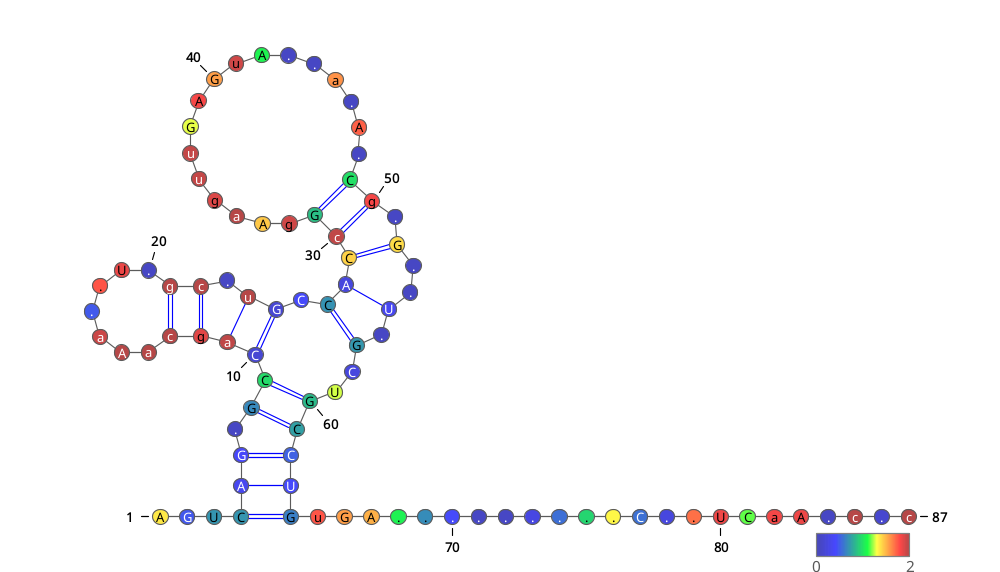

In [67]:
# creat the shannon entropy of CM designs

alignment = AlignIO.read(designs_file_CM, "stockholm")
n = alignment.get_alignment_length()
N = len(alignment)

shannon_entropies = []
chars = list('ACGU')
for i in range(n):
    col = alignment[:, i].upper()
    unique_chars = set(col)
    frequencies = [ col.count(char)/N for char in unique_chars]
    shannon = - np.sum([freq * np.log2(freq) for freq in frequencies])
    shannon_entropies.append(shannon)

seq = RF
ss = SS_cons
v = varnaapi.Structure(sequence=seq, structure=ss)


v.update(baseNum='black', drawBackbone=True, drawBases=True, fillBases=True, spaceBetweenBases=1, flat=True, resolution=2.5)
v.add_colormap(shannon_entropies, vMin=0, vMax=2, style='energy')

#v.flip(100)
# v.savefig('/scr/aldea/kgutenbrunner/working/thesis/images/CM_shannon_entropy.png')
v.show()

## base pairing heatmap

In [68]:
# calculate the mfe structure for each sequence and create a heatmap of it

bps = []
records = list(SeqIO.parse(designs_file_CM, "stockholm"))

for record in records:
    seq = str(record.seq)
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    BPP = fc.bpp()
    # Create the mirrored array
    mirrored_array = np.triu(BPP) + np.triu(BPP, 1).T
    bps.append(np.array(mirrored_array))

bps = np.sum(bps, axis=0)
bps /= N
CM_bps = bps


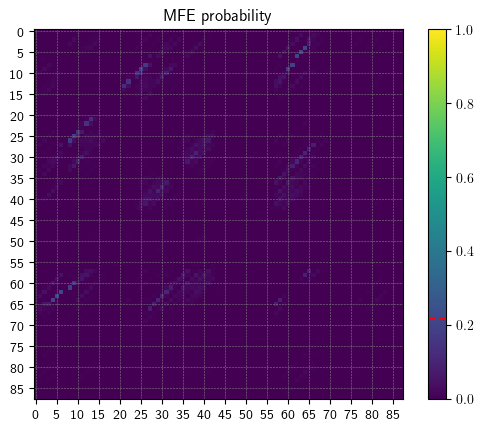

<Figure size 640x480 with 0 Axes>

In [69]:
bp_plot(np.nan_to_num(CM_bps))

## length distribution

In [70]:
records = list(SeqIO.parse(designs_file_CM, "stockholm"))
CM_design_sequences = [str(record.seq) for record in records]


In [71]:
# get lengths of each sequence
sequence_lengths = [get_length(seq) - 3 for seq in CM_design_sequences]


(array([ 3.,  4., 12., 19., 29., 23.,  5.,  3.,  1.,  1.]),
 array([49., 51., 53., 55., 57., 59., 61., 63., 65., 67., 69.]),
 <BarContainer object of 10 artists>)

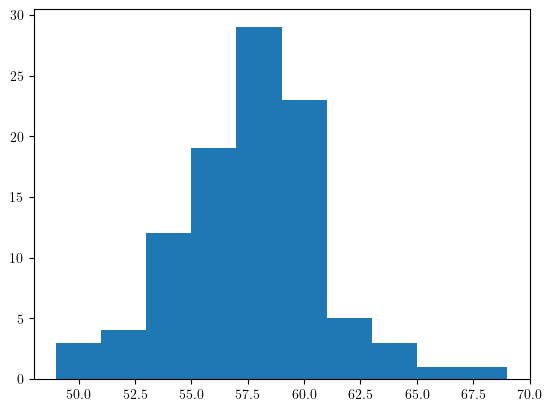

In [72]:
# plot histogram of lengths
plt.hist(sequence_lengths)

In [73]:
CM_sequence_lengths = sequence_lengths

## boxplot of lengths

In [74]:
# get all the lengths of the different parts of the ss
alpha_lens =[]
alpha_stem_lens =[]
beta_stem_lens =[]
beta_hl_lens =[]
beta_lens=[]
gamma_stem_lens =[]
gamma_hl_lens  = []
gamma_lens  = []

structures = find_structure(SS_cons)
for seq in CM_design_sequences:
    alpha_stem, alpha, beta_stem, beta_hl, beta, gamma_stem, gamma_hl, gamma = get_length_of_structures(seq, structures)
    alpha_lens.append(alpha)
    alpha_stem_lens.append(alpha_stem)
    beta_stem_lens.append(beta_stem)
    beta_hl_lens.append(beta_hl)
    beta_lens.append(beta)
    gamma_stem_lens.append(gamma_stem)
    gamma_hl_lens.append(gamma_hl)
    gamma_lens.append(gamma)

In [75]:
lens_dict = {
    'alpha_stems_lens': alpha_stem_lens,
    'alpha_lens': alpha_lens,
    'beta_stem_lens': beta_stem_lens,
    'beta_hl_lens': beta_hl_lens,
    'beta_lens': beta_lens,
    'gamma_stem_lens': gamma_stem_lens,
    'gamma_hl_lens': gamma_hl_lens,
    'gamma_lens': gamma_lens,
}

df_CM_lens = pd.DataFrame(lens_dict)

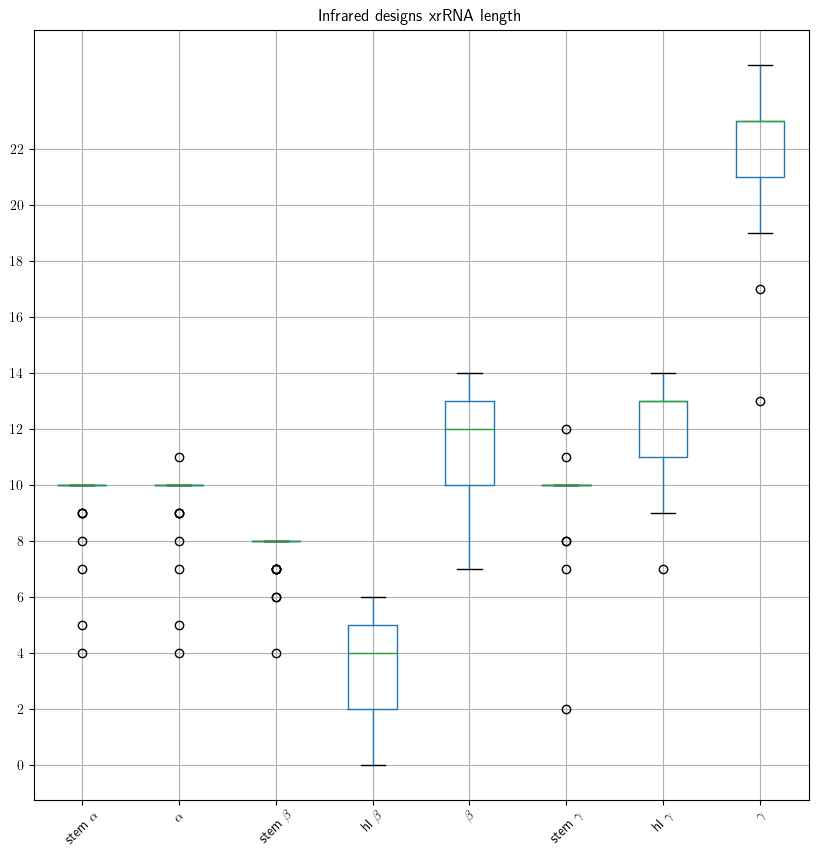

In [76]:
# create boxplot of different lengths

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 10))
df_CM_lens.boxplot()
plt.title('Infrared designs xrRNA length')

labels = [r'stem $\alpha$', r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$']
plt.xticks(list(range(1, len(labels)+1)), labels, rotation=45)
plt.yticks(np.arange(0, 24, step=2))
plt.show()
# save_file = os.path.join(base_folder, 'thesis/images/xrRNA_analysis_boxplot.png')
# plt.savefig(save_file)

## Pseudo knots

In [77]:
possible_pairs = [('A', 'U'), ('C', 'G'), ('G', 'C'), ('G', 'U'), ('U', 'A'), ('U', 'G')]
def check_bp(seq, position):
    if (seq[position[0]], seq[position[1]]) in possible_pairs:
        return True
    else:
        return False
    
alpha, beta, gamma = find_structure(SS_cons)

pk1_bps = [(0, gamma[-1] + 2), (1, gamma[-1] + 1)]

possible_PK2_region = (list(range(gamma[int(len(gamma)/2)-1]+1, gamma[int(len(gamma)/2)])) + list(range(alpha[-1]+1, len(SS_cons))))
hard_constraints_pk2 = ['.' if i in possible_PK2_region else 'x' for i in range(len(SS_cons)) ]
hard_constraints_pk2 = ''.join(hard_constraints_pk2)


In [78]:
CM_pk1_counter =  0
CM_pk1_both = 0

CM_pk2_counter = 0
CM_pk2_bps = []

CM_both_pks = 0

for seq in CM_design_sequences:
    both_bps = 0
    for bp in pk1_bps:
        if check_bp(seq, bp):
            CM_pk1_counter+=145

    # Apply the constraint
    fc.hc_add_from_db(constraints)

    # Compute the secondary structure with the constraint applied
    structure, mfe = fc.mfe()  # mfe() computes the Minimum Free Energy (MFE) secondary structure

    if mfe != 0:
        if bp_between_regions(constraints, structure):
            CM_pk2_counter += 145


CM_pk1_counter /= (len(CM_design_sequences) * len(pk1_bps))
CM_pk1_both /= len(CM_design_sequences)
CM_pk2_counter /= len(CM_design_sequences)
CM_both_pks /= len(CM_design_sequences)



print('PK1:\t\t\t', CM_pk1_counter)
print('mean # of PK2 bps:\t', CM_pk1_both)
        
print('\nPK2:\t\t\t', CM_pk2_counter)
print('mean # of PK2 bps:\t', round(np.mean(CM_pk2_bps), 2))



print('\nboth PKs:\t\t', CM_both_pks)



PK1:			 0.775
mean # of PK2 bps:	 0.58

PK2:			 0.45
mean # of PK2 bps:	 5.11

both PKs:		 0.27


# all combined

## boxplot of lengths

In [79]:
rename_mapping = {
    'stemA': 'alpha_stems_lens',
 'ibA': 'aplha_bulge_lens',
 'alpha': 'alpha_lens',
 'stemB': 'beta_stem_lens',
 'hlB': 'beta_hl_lens',
 'beta': 'beta_lens',
 'stemG': 'gamma_stem_lens',
 'hlG': 'gamma_hl_lens',
 'gamma': 'gamma_lens',
 'bPK': 'until_pk2_lens',
 'n_PK': 'pk2_lens',
 'PK1bPK2': 'between_pks_lens',
 'b_PK': 'before_pk2_lens',
 'a_PK': 'after_pk2_lens'}

df_MBFV = df_MBFV.rename(columns=rename_mapping)

In [80]:
old_cols = list(df_MBFV.columns)
old_cols.remove('name')
old_cols.remove('len')
new_cols =list(df_IR_lens.columns)
rename_mapping = {old_cols[i]: new_cols[i] for i in range(len(new_cols))}
df_MBFV = df_MBFV.rename(columns=rename_mapping)

In [81]:
df_IR_lens['model'] = 'Infrared'
df_CM_lens['model'] = 'CM'
df_MBFV['model'] = 'MBFV'
MBFV_temp = df_MBFV.drop(columns=['name', 'len'])

combined = pd.concat([MBFV_temp, df_IR_lens, df_CM_lens], ignore_index=True, sort=False)

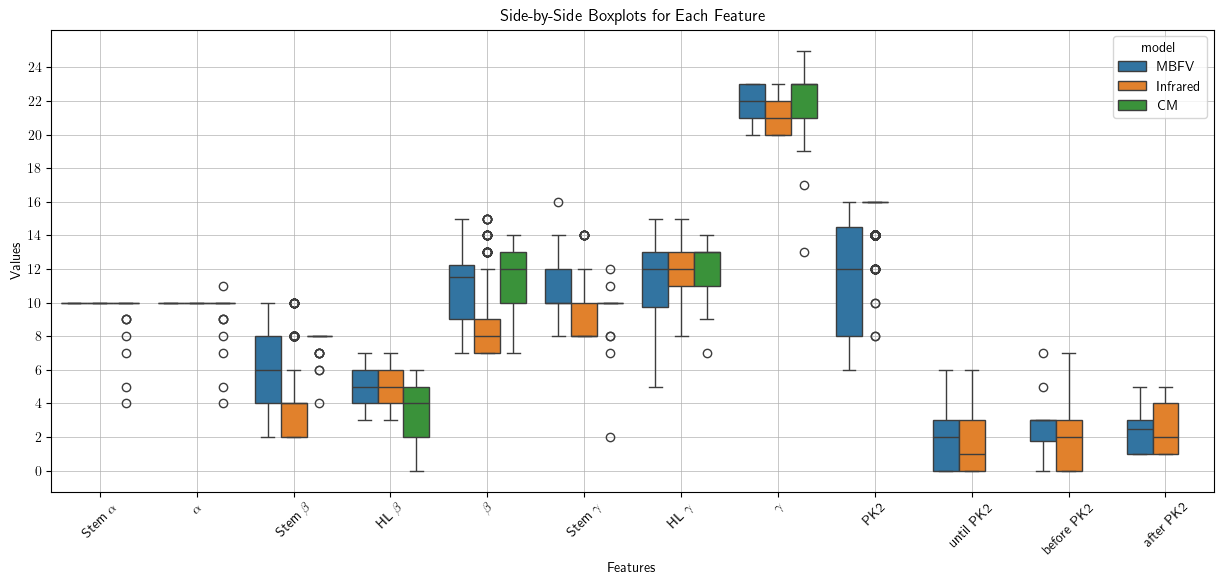

In [82]:
# Melt the DataFrame to have 'feature' as one column, and 'value' as another column
melted = pd.melt(combined, id_vars='model', var_name='feature', value_name='value')

custom_palette = {
    'MBFV': MBFV_color,  # Blue for Model1
    'Infrared': IR_color,  # Orange for Model2
    'CM': CM_color   # Green for Model3
}

# Create the boxplot, showing features on the x-axis, and the values on the y-axis
plt.figure(figsize=(15, 6))
sns.boxplot(x='feature', y='value', hue='model', data=melted)

# Set title and labels
plt.title('Side-by-Side Boxplots for Each Feature')
plt.xlabel('Features')
plt.ylabel('Values')
labels = [r'Stem $\alpha$', r'$\alpha$', r'Stem $\beta$', r'HL $\beta$', r'$\beta$', r'Stem $\gamma$', r'HL $\gamma$', r'$\gamma$', 'PK2', 'until PK2', 'before PK2', 'after PK2']
plt.xticks(list(range(len(labels))), labels, rotation=45)

plt.grid(True, which='both', linestyle='-', linewidth=0.7, alpha=0.7)

max_value = melted['value'].max()  # Get the max value from the 'value' column
plt.yticks(np.arange(0, max_value + 1, 2))  # Adjust the step size here

# Display the plot
plt.show()


## length distribution

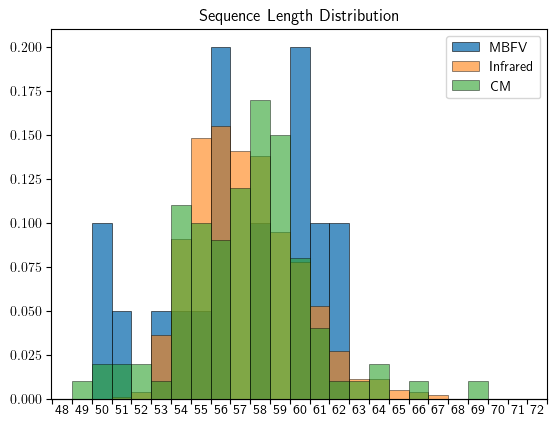

In [83]:

fig, ax = plt.subplots()
linewidth = 0.5
min_value = int(min(MBFV_sequence_lengths))  # Minimum value in the data
max_value = int(max(MBFV_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax.hist(MBFV_sequence_lengths, bins=bins, linewidth=linewidth, edgecolor='black',alpha=0.8, density=True,label='MBFV')


min_value = int(min(IR_sequence_lengths))  # Minimum value in the data
max_value = int(max(IR_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax.hist(IR_sequence_lengths, bins=bins, linewidth=linewidth,edgecolor='black',alpha=0.6, density=True,label='Infrared')

min_value = int(min(CM_sequence_lengths))  # Minimum value in the data
max_value = int(max(CM_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax.hist(CM_sequence_lengths, bins=bins, linewidth=linewidth,edgecolor='black',alpha=0.6, density=True,label='CM')

bins = np.arange(48, 72 + 2, 1)  # +2 to include the last bin
ax.set_xticks(bins, ['']*len(bins))
sec = ax.secondary_xaxis(location=0)
sec.set_xticks(bins+0.5, bins)
sec.tick_params('x', length=0)
# plt.xticks(list(range(48, 72, 2)))
#plt.legend(['MBFV', 'Infrared', 'CM'], title='Model', frameon=True)
plt.legend()
plt.title('Sequence Length Distribution')
save_fig = '/scr/aldea/kgutenbrunner/working/thesis/images/MBFV_length_dist.png'
#plt.savefig(save_fig)


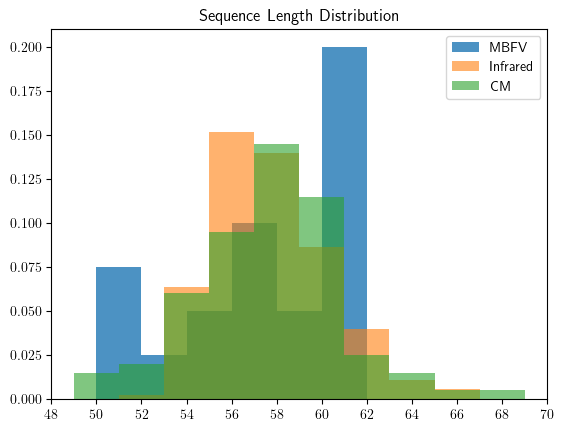

In [84]:


linewidth = 0.
min_value = int(min(MBFV_sequence_lengths))  # Minimum value in the data
max_value = int(max(MBFV_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 2)  # +2 to include the last bin
plt.hist(MBFV_sequence_lengths, bins=bins, linewidth=linewidth, edgecolor='black',alpha=0.8, density=True,label='MBFV')


min_value = int(min(IR_sequence_lengths))  # Minimum value in the data
max_value = int(max(IR_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 2)  # +2 to include the last bin
plt.hist(IR_sequence_lengths, bins=bins, linewidth=linewidth,edgecolor='black',alpha=0.6, density=True,label='Infrared')

min_value = int(min(CM_sequence_lengths))  # Minimum value in the data
max_value = int(max(CM_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 2)  # +2 to include the last bin
plt.hist(CM_sequence_lengths, bins=bins, linewidth=linewidth,edgecolor='black',alpha=0.6, density=True,label='CM')


plt.xticks(list(range(48, 72, 2)))
#plt.legend(['MBFV', 'Infrared', 'CM'], title='Model', frameon=True)
plt.legend()
plt.title('Sequence Length Distribution')
save_fig = '/scr/aldea/kgutenbrunner/working/thesis/images/MBFV_length_dist.png'
#plt.savefig(save_fig)


## logo counts

In [85]:
def insert_zero_row(df, positions):
    zero_row = pd.DataFrame([np.zeros(len(df.columns))], columns=df.columns)
    for position in positions:
        df_top = df.iloc[:position]
        df_bottom = df.iloc[position:]
        df = pd.concat([df_top, zero_row, df_bottom], ignore_index=True)
    return df

def remove_row(df, row_index):
    for i in row_index:
        df = df.drop(index=i, inplace=False).reset_index(drop=True)
    return df

def remove_rows_below_threshold(df, threshold):
    row_sums = df.sum(axis=1)
    df_filtered = df[row_sums >= threshold].reset_index(drop=True)
    return df_filtered

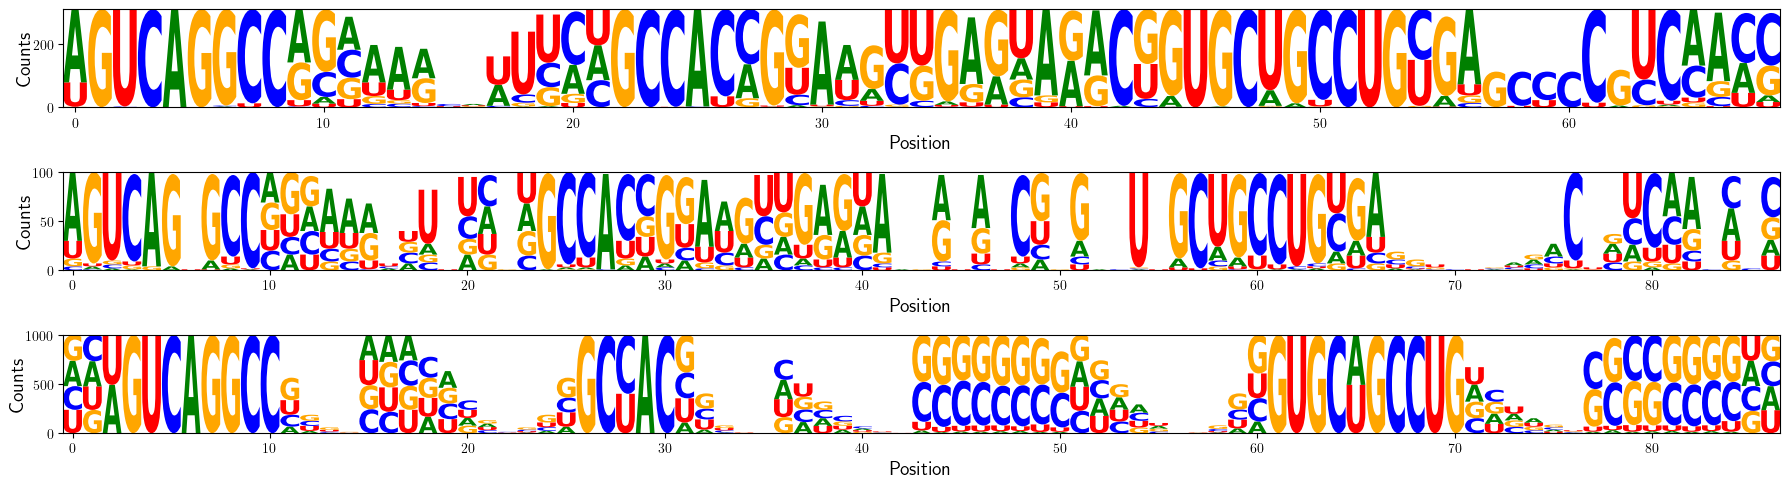

In [86]:
# Function to pad alignment matrix to a specific length
def pad_alignment_matrix(alignment_df, max_length):
    current_length = alignment_df.shape[0]
    if current_length < max_length:
        padding_df = pd.DataFrame(0, index=np.arange(current_length, max_length), columns=alignment_df.columns)
        alignment_df = pd.concat([alignment_df, padding_df])
    return alignment_df

# Creating Counts Sequence Logo from CM
CM_alignment = AlignIO.read(designs_file_CM, "stockholm")
CM_sequences = [str(record.seq).upper() for record in CM_alignment]
CM_alignment_df = logomaker.alignment_to_matrix(CM_sequences)

# Creating Counts Sequence Logo from Infrared
IR_alignment = AlignIO.read(IR_seqs_file, "fasta")
IR_sequences = [str(record.seq).upper() for record in IR_alignment]
IR_alignment_df = logomaker.alignment_to_matrix(IR_sequences)

# Creating Counts Sequence Logo from MBFV data
MBFV_input_file = os.path.join(base_folder, 'cov_model/MBFV_xrRNA1/stk_files/combined.out/results/result.aln')
MBFV_alignment = AlignIO.read(MBFV_input_file, "clustal")
MBFV_sequences = [str(record.seq).upper() for record in MBFV_alignment]
MBFV_alignment_df = logomaker.alignment_to_matrix(MBFV_sequences)

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 5))  # Adjust height to fit all logos

# MBFV logo on the first subplot
logo_MBFV = logomaker.Logo(MBFV_alignment_df, ax=axes[0], color_scheme="classic")
logo_MBFV.ax.set_xlabel('Position', fontsize=14)
logo_MBFV.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# CM logo on the second subplot
logo_CM = logomaker.Logo(CM_alignment_df, ax=axes[1], color_scheme="classic")
logo_CM.ax.set_xlabel('Position', fontsize=14)
logo_CM.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# IR logo on the third subplot
logo_IR = logomaker.Logo(IR_alignment_df, ax=axes[2], color_scheme="classic")
logo_IR.ax.set_xlabel('Position', fontsize=14)
logo_IR.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


/tmp/ipykernel_804673/4129866510.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  padded_MBFV_alignment_df['X'] = (padded_MBFV_alignment_df == 0).all(axis=1).replace({True: len(MBFV_sequences), False: 0})
/tmp/ipykernel_804673/4129866510.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  padded_CM_alignment_df['X'] = (padded_CM_alignment_df == 0).all(axis=1).replace({True: len(CM_sequences), False: 0})
/tmp/ipykernel_804673/4129866510.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed i

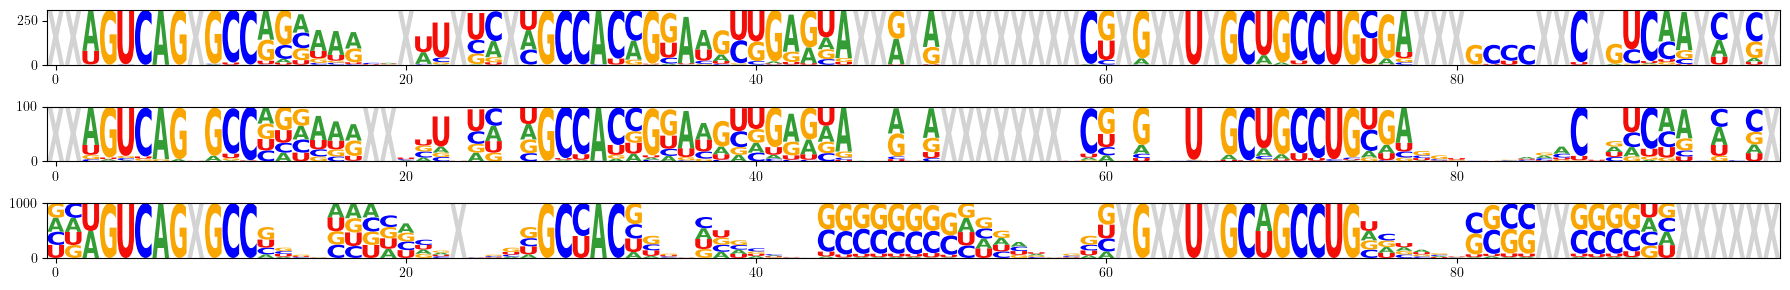

In [87]:
adjusted_MBFV = MBFV_alignment_df[~(MBFV_alignment_df == 0).all(axis=1)]
adjusted_CM = CM_alignment_df[~(CM_alignment_df == 0).all(axis=1)]
adjusted_IR = IR_alignment_df[~(IR_alignment_df == 0).all(axis=1)]

# adjusting length for better comparability
# MBFV
adjusted_MBFV = insert_zero_row(adjusted_MBFV, [0,1, 8, 20, 23, 26, 46, 46, 49, 51, 54, 56, 56, 59, 75, 75, 87]) #adjusting it to CM
adjusted_MBFV = insert_zero_row(adjusted_MBFV, [51, 51, 51, 51, 51, 51, 51,78,78,78, 88, 94, 96]) # adjusting it to IR

# CM
adjusted_CM = insert_zero_row(adjusted_CM, [0,1, 18, 18]) # adjusting it to MBFV
adjusted_CM = insert_zero_row(adjusted_CM, [51, 51, 51, 51, 51, 51, 51 ]) # adjusting it to IR

# IR
adjusted_IR = insert_zero_row(adjusted_IR, [8, 23, 61,63,63,66,85,85])

max_length = max(adjusted_IR.shape[0], adjusted_MBFV.shape[0], adjusted_CM.shape[0])

# Pad the alignments to the same length
padded_MBFV_alignment_df = pad_alignment_matrix(adjusted_MBFV, max_length)
padded_CM_alignment_df = pad_alignment_matrix(adjusted_CM, max_length)
padded_IR_alignment_df = pad_alignment_matrix(adjusted_IR, max_length)

padded_MBFV_alignment_df['X'] = (padded_MBFV_alignment_df == 0).all(axis=1).replace({True: len(MBFV_sequences), False: 0})
padded_CM_alignment_df['X'] = (padded_CM_alignment_df == 0).all(axis=1).replace({True: len(CM_sequences), False: 0})
padded_IR_alignment_df['X'] = (padded_IR_alignment_df == 0).all(axis=1).replace({True: len(IR_sequences), False: 0})

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 3))  # Adjust height to fit all logos

color_scheme = {
    'A':'#349c34',
    'C':'#0000ff',
    'G':'#f9a603',
    'U':'#f30e08',
    'X':'lightgrey',
    'K':'lightgrey',
    'M':'lightgrey',
    'R':'lightgrey',
    'W':'lightgrey',
    'Y':'lightgrey',}

logo_MBFV = logomaker.Logo(padded_MBFV_alignment_df, ax=axes[0], color_scheme=color_scheme)
logo_CM = logomaker.Logo(padded_CM_alignment_df, ax=axes[1], color_scheme=color_scheme)
logo_IR = logomaker.Logo(padded_IR_alignment_df, ax=axes[2], color_scheme=color_scheme)

plt.tight_layout()
plt.show()

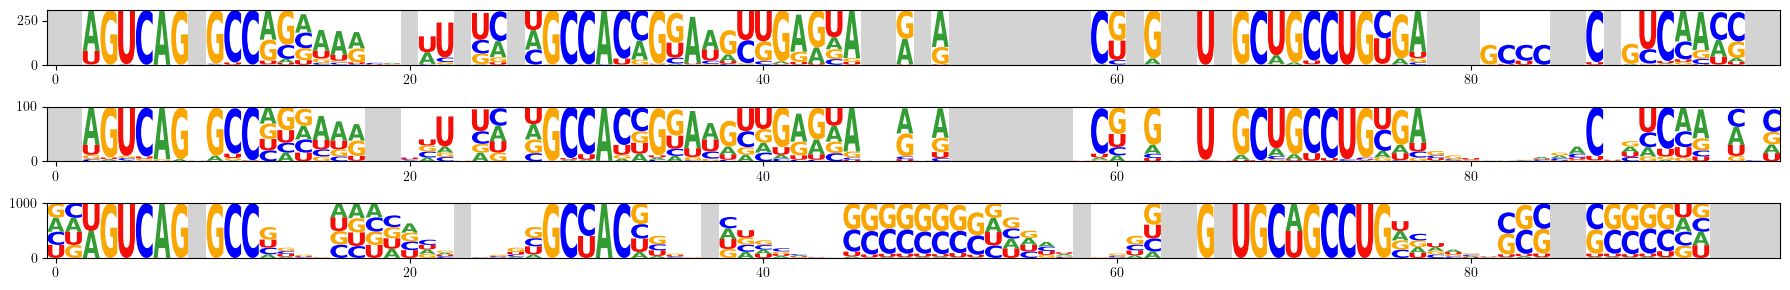

In [88]:
# adjusting length for better comparability
# MBFV
adjusted_MBFV = insert_zero_row(MBFV_alignment_df, [0,1, 8, 20, 23, 26, 46, 46, 49, 51, 54, 56, 56, 59, 75, 75, 87,]) #adjusting it to CM
adjusted_MBFV = insert_zero_row(adjusted_MBFV, [51, 51, 51, 51, 51, 51, 51,78,78,78, 88]) # adjusting it to IR

# CM
adjusted_CM = insert_zero_row(CM_alignment_df, [0,1, 18, 18]) # adjusting it to MBFV
adjusted_CM = insert_zero_row(adjusted_CM, [51, 51, 51, 51, 51, 51, 51 ]) # adjusting it to IR


# IR
adjusted_IR = insert_zero_row(IR_alignment_df, [8, 23, 63, 63, 66,85,85])


max_length = max(adjusted_IR.shape[0], adjusted_MBFV.shape[0], adjusted_CM.shape[0])

# Pad the alignments to the same length
padded_MBFV_alignment_df = pad_alignment_matrix(adjusted_MBFV, max_length)
padded_CM_alignment_df = pad_alignment_matrix(adjusted_CM, max_length)
padded_IR_alignment_df = pad_alignment_matrix(adjusted_IR, max_length)


MBFV_X = padded_MBFV_alignment_df.index[(padded_MBFV_alignment_df == 0).all(axis=1)].tolist()
CM_X =  padded_CM_alignment_df.index[(padded_CM_alignment_df == 0).all(axis=1)].tolist()
IR_X =  padded_IR_alignment_df.index[(padded_IR_alignment_df == 0).all(axis=1)].tolist()




# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 3))  # Adjust height to fit all logos

color_scheme = {
    'A':'#349c34',
    'C':'#0000ff',
    'G':'#f9a603',
    'U':'#f30e08',
    'K':'lightgrey',
    'M':'lightgrey',
    'R':'lightgrey',
    'W':'lightgrey',
    'Y':'lightgrey',}

logo_MBFV = logomaker.Logo(padded_MBFV_alignment_df, ax=axes[0], color_scheme=color_scheme)
logo_CM = logomaker.Logo(padded_CM_alignment_df, ax=axes[1], color_scheme=color_scheme)
logo_IR = logomaker.Logo(padded_IR_alignment_df, ax=axes[2], color_scheme=color_scheme)

for x in MBFV_X:
    logo_MBFV.highlight_position(p=x, color='lightgrey', alpha=1)

for x in CM_X:
    logo_CM.highlight_position(p=x, color='lightgrey', alpha=1)

for x in IR_X:
    logo_IR.highlight_position(p=x, color='lightgrey', alpha=1)


plt.tight_layout()
plt.show()

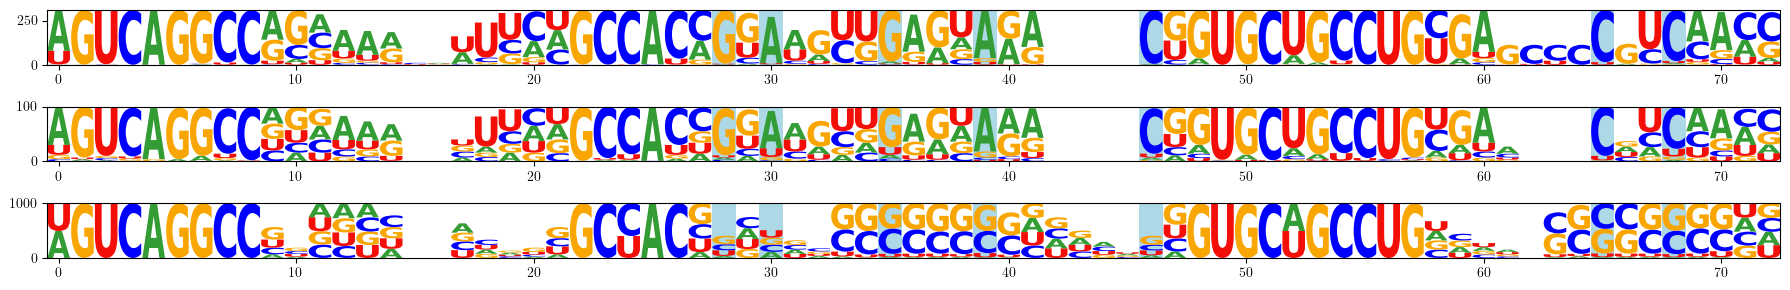

In [89]:
# adjusting length for better comparability
# MBFV
adjusted_MBFV = remove_rows_below_threshold(MBFV_alignment_df, 1)
45
adjusted_IR = remove_rows_below_threshold(IR_alignment_df, 100)

adjusted_IR = remove_row(adjusted_IR, [0,0])

# adjusting length for better comparability
# MBFV
adjusted_MBFV = insert_zero_row(adjusted_MBFV, [42,42,42,42]) #adjusting it to CM
# CM
adjusted_CM = insert_zero_row(adjusted_CM, [15,15, 42,42,42,42,62,62,62]) # adjusting it to MBFV
# IR

adjusted_IR = insert_zero_row(adjusted_IR, [15,15,62,])


max_length = max(adjusted_IR.shape[0], adjusted_MBFV.shape[0], adjusted_CM.shape[0])

# Pad the alignments to the same length
padded_MBFV_alignment_df = pad_alignment_matrix(adjusted_MBFV, max_length)
padded_CM_alignment_df = pad_alignment_matrix(adjusted_CM, max_length)
padded_IR_alignment_df = pad_alignment_matrix(adjusted_IR, max_length)


# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 3))  # Adjust height to fit all logos

color_scheme = {
    'A':'#349c34',
    'C':'#0000ff',
    'G':'#f9a603',
    'U':'#f30e08',
    'K':'lightgrey',
    'M':'lightgrey',
    'R':'lightgrey',
    'W':'lightgrey',
    'Y':'lightgrey',}

logo_MBFV = logomaker.Logo(padded_MBFV_alignment_df, ax=axes[0], color_scheme=color_scheme)
logo_CM = logomaker.Logo(padded_CM_alignment_df, ax=axes[1], color_scheme=color_scheme)
logo_IR = logomaker.Logo(padded_IR_alignment_df, ax=axes[2], color_scheme=color_scheme)


positions = [28, 30, 35, 39, 46, 65,68]
for x in positions:
    logo_MBFV.highlight_position(p=x, color='lightblue', alpha=1)
    logo_CM.highlight_position(p=x, color='lightblue', alpha=1)
    logo_IR.highlight_position(p=x, color='lightblue', alpha=1)


plt.tight_layout()
plt.show()

Inconsistency: <br>
Used IUPAC from Denis Master thesis (page 54) --> this should be nt that have 90% conservation. But on page 40, we have an alignment, that shows something different.<br>
unused conserved NT:
- G in 28
- A in 30
- G in 35
- A in 39
- C in 46
- C in 65
- C in 68

in denis work there are all not totally conserved
- G in 28 --> ~60%
- A in 30 --> ~70%
- G in 35 --> ~60%
- A in 39 --> ~70%
- C in 46 --> ~85%
- C in 65 --> ~80%
- C in 68 --> ~50%


two options:
- use Denis alignment for comparison
- add these findings into my sequence design

### done with selected MBFVs

In [90]:
# Creating Counts Sequence Logo from MBFV data
MBFV_input_file = os.path.join(base_folder, '/scr/aldea/kgutenbrunner/DENIS/MBFV/working/all_MBFV_xrRNA/selected_xrRNA1.aln')
MBFV_selected_alignment = AlignIO.read(MBFV_input_file, "fasta")

# Creating Counts Sequence Logo from CM
CM_alignment = AlignIO.read(designs_file_CM, "stockholm")
MBFV_selected_sequences = [str(record.seq).upper() for record in MBFV_selected_alignment]
MBFV_selected_df = logomaker.alignment_to_matrix(MBFV_selected_sequences)

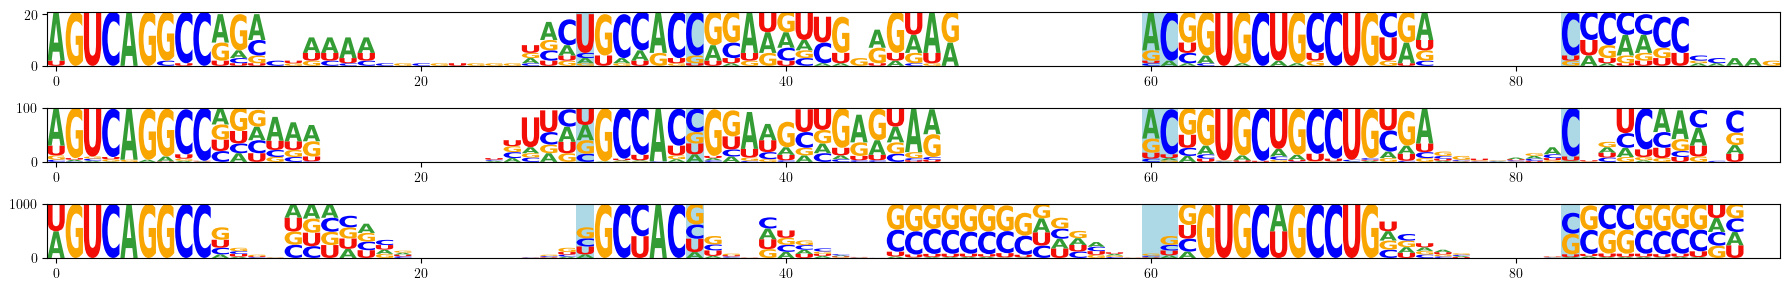

In [91]:
# adjusting length for better comparability
# MBFV
adjusted_MBFV = remove_rows_below_threshold(MBFV_selected_df, 1)

# CM
adjusted_CM = remove_rows_below_threshold(CM_alignment_df, 2)

# IR
adjusted_IR = remove_rows_below_threshold(IR_alignment_df, 1)

# MBFV
adjusted_MBFV = insert_zero_row(adjusted_MBFV, [50,50,50,50,50,50,50,50,50,50,76,76,76,76,76,76,76]) #adjusting it to CM
# CM
adjusted_CM = insert_zero_row(adjusted_CM, [15,15,15,15,15,15,15,15,15,49,49,49,49,49,49,49,49,49,49,49]) # adjusting it to MBFV
# IR
adjusted_IR = remove_row(adjusted_IR, [0,0])
adjusted_IR = insert_zero_row(adjusted_IR, [20,20,20,20,20,20,78,78,78,78])

max_length = max(adjusted_IR.shape[0], adjusted_MBFV.shape[0], adjusted_CM.shape[0])

# Pad the alignments to the same length
padded_MBFV_alignment_df = pad_alignment_matrix(adjusted_MBFV, max_length)
padded_CM_alignment_df = pad_alignment_matrix(adjusted_CM, max_length)
padded_IR_alignment_df = pad_alignment_matrix(adjusted_IR, max_length)


# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 3))  # Adjust height to fit all logos

color_scheme = {'A':'#349c34','C':'#0000ff','G':'#f9a603','U':'#f30e08',
    'K':'lightgrey','M':'lightgrey','R':'lightgrey','W':'lightgrey','Y':'lightgrey',}

logo_MBFV = logomaker.Logo(padded_MBFV_alignment_df, ax=axes[0], color_scheme=color_scheme)
logo_CM = logomaker.Logo(padded_CM_alignment_df, ax=axes[1], color_scheme=color_scheme)
logo_IR = logomaker.Logo(padded_IR_alignment_df, ax=axes[2], color_scheme=color_scheme)


positions = [29,35,60,61,83]
for x in positions:
    logo_MBFV.highlight_position(p=x, color='lightblue', alpha=1)
    logo_CM.highlight_position(p=x, color='lightblue', alpha=1)
    logo_IR.highlight_position(p=x, color='lightblue', alpha=1)


plt.tight_layout()
plt.show()

## MFE comparison

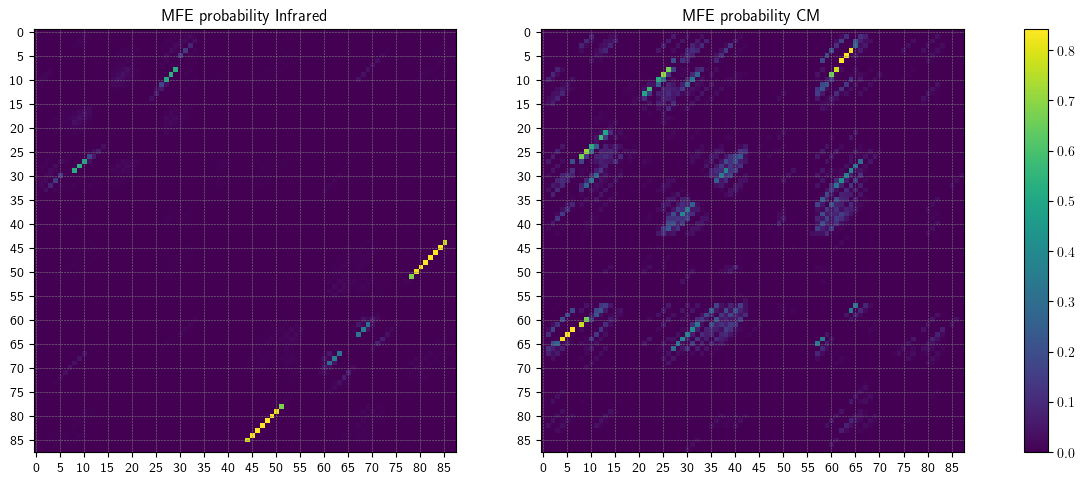

In [92]:
# get base pairing heatmap of a matrix of base pair probabilities

fig, axes = plt.subplots(1, 2, figsize=(12,9))
img1 = axes[0].imshow(IR_bps, cmap='viridis', interpolation='nearest')
axes[0].set_xticks(np.arange(0, IR_bps.shape[1], 5), np.arange(0, IR_bps.shape[1], 5))
axes[0].set_yticks(np.arange(0, IR_bps.shape[0], 5), np.arange(0, IR_bps.shape[0], 5))
axes[0].set_title('MFE probability Infrared')
axes[0].grid(color='gray', linestyle='--', linewidth=0.4)

img2 = axes[1].imshow(CM_bps, cmap='viridis', interpolation='nearest')
axes[1].set_xticks(np.arange(0, CM_bps.shape[1], 5), np.arange(0, CM_bps.shape[1], 5))
axes[1].set_yticks(np.arange(0, CM_bps.shape[0], 5), np.arange(0, CM_bps.shape[0], 5))
axes[1].set_title('MFE probability CM')
axes[1].grid(color='gray', linestyle='--', linewidth=0.4)
# print([axes[1].get_position().x1-0.25,axes[1].get_position().y0,0.02,axes[0].get_position().y1-axes[1].get_position().y0])
cax = fig.add_axes([0.95, 0.26, 0.02,axes[0].get_position().y1-axes[1].get_position().y0])
fig.colorbar(img1, cax=cax)


plt.show()


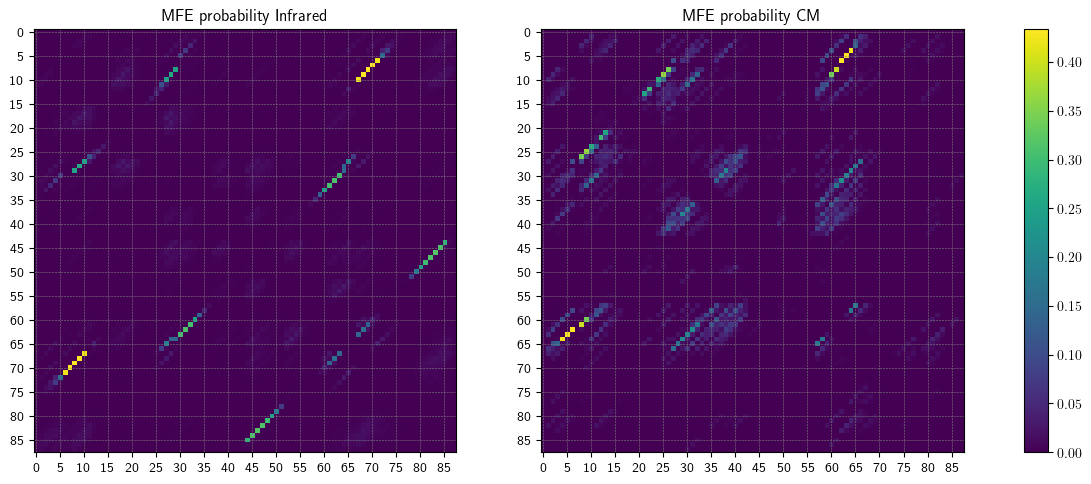

In [93]:
# get base pairing heatmap of a matrix of base pair probabilities

fig, axes = plt.subplots(1, 2, figsize=(12,9))
img1 = axes[0].imshow(IR_new_w_bps, cmap='viridis', interpolation='nearest')
axes[0].set_xticks(np.arange(0, IR_new_w_bps.shape[1], 5), np.arange(0, IR_new_w_bps.shape[1], 5))
axes[0].set_yticks(np.arange(0, IR_new_w_bps.shape[0], 5), np.arange(0, IR_new_w_bps.shape[0], 5))
axes[0].set_title('MFE probability Infrared')
axes[0].grid(color='gray', linestyle='--', linewidth=0.4)

img2 = axes[1].imshow(CM_bps, cmap='viridis', interpolation='nearest')
axes[1].set_xticks(np.arange(0, CM_bps.shape[1], 5), np.arange(0, CM_bps.shape[1], 5))
axes[1].set_yticks(np.arange(0, CM_bps.shape[0], 5), np.arange(0, CM_bps.shape[0], 5))
axes[1].set_title('MFE probability CM')
axes[1].grid(color='gray', linestyle='--', linewidth=0.4)
# print([axes[1].get_position().x1-0.25,axes[1].get_position().y0,0.02,axes[0].get_position().y1-axes[1].get_position().y0])
cax = fig.add_axes([0.95, 0.26, 0.02,axes[0].get_position().y1-axes[1].get_position().y0])
fig.colorbar(img1, cax=cax)


plt.show()


## Hamming Distance

In [94]:
from Bio import pairwise2
from tqdm import tqdm

/home/mescalin/kgutenbrunner/.conda/envs/rna_analysis/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [95]:
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strand lengths are not equal!")
    return sum(ch1 != ch2 for ch1,ch2 in zip(s1,s2))

In [96]:
minimal_distances = []
for CM_seq in tqdm(CM_sequences):
    CM_seq = CM_seq.replace('-','')
    min_dist = len(CM_seq)
    for MBFV_seq in MBFV_sequences:
        MBFV_seq = MBFV_seq.replace('-','')
        alignments = pairwise2.align.globalxx(CM_seq, MBFV_seq)
        seqA, seqB = alignments[0].seqA, alignments[0].seqB
        ham_dis = hamming_distance(seqA,seqB)
        if ham_dis < min_dist:
            min_dist = ham_dis
    minimal_distances.append(min_dist)

100%|██████████| 100/100 [04:30<00:00,  2.71s/it]


In [97]:
CM_minimal_distances = minimal_distances


In [98]:
minimal_distances = []
for IR_seq in tqdm(IR_sequences[0:100]):
    IR_seq = IR_seq.replace('-','')
    min_dist = len(IR_seq)
    for MBFV_seq in MBFV_sequences:
        MBFV_seq = MBFV_seq.replace('-','')
        alignments = pairwise2.align.globalxx(IR_seq, MBFV_seq)
        seqA, seqB = alignments[0].seqA, alignments[0].seqB
        ham_dis = hamming_distance(seqA,seqB)
        if ham_dis < min_dist:
            min_dist = ham_dis
    minimal_distances.append(min_dist)


 90%|█████████ | 90/100 [04:10<00:27,  2.79s/it]


KeyboardInterrupt: 

In [ ]:
IR_minimal_distances = minimal_distances


Text(0.5, 1.0, 'Sequence Length Distribution')

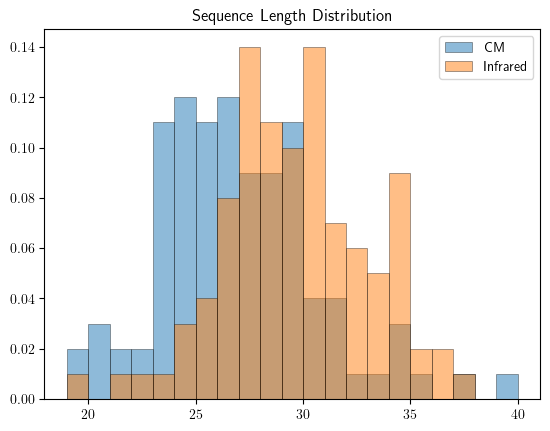

In [ ]:

fig, ax = plt.subplots()
linewidth = 0.5

min_value = int(min(CM_minimal_distances))  # Minimum value in the data
max_value = int(max(CM_minimal_distances))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax.hist(CM_minimal_distances, bins=bins, linewidth=linewidth,edgecolor='black',alpha=0.5, density=True,label='CM')

min_value = int(min(IR_minimal_distances))  # Minimum value in the data
max_value = int(max(IR_minimal_distances))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax.hist(IR_minimal_distances, bins=bins, linewidth=linewidth,edgecolor='black',alpha=0.5, density=True,label='Infrared')

# bins = np.arange(48, 72 + 2, 1)  # +2 to include the last bin
# ax.set_xticks(bins, ['']*len(bins))
# sec = ax.secondary_xaxis(location=0)
# sec.set_xticks(bins+0.5, bins)
# sec.tick_params('x', length=0)
# plt.xticks(list(range(48, 72, 2)))
#plt.legend(['MBFV', 'Infrared', 'CM'], title='Model', frameon=True)
plt.legend()
plt.title('Sequence Length Distribution')
# save_fig = '/scr/aldea/kgutenbrunner/working/thesis/images/MBFV_length_dist.png'
#plt.savefig(save_fig)


# CM 3D simulation test

In [ ]:
seq = 'AGUCAGACCGCGUAUCGCGCCACCGGAAGGAGAGAAACGGUGCUGUCUGUGACAUCCGCCG'
fc = RNA.fold_compound(seq)
fc.pf()
ss, mfe = fc.mfe()
print(seq)
print(ss)
print(mfe)
v = varnaapi.Structure(sequence=seq, structure=ss)
v.show()

AGUCAGGCCAUCUAAcUGAUGUCACCGCACGUUUAGAGACGGUGCUGCCUGUAACACUCUC
...(((((((((.....)))).((((((.(.....).).)))))..)))))..........
-14.600000381469727


Output file: /var/folders/54/ry4wc1s953jdm1j76gdcpwpc0000gn/T/tmp2bfijw89.svg



JupyterSvgImage(svg='<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" \n"http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n\n<svg width="334.1527545270176px" height="322px" version="1.1" viewBox="0 0 400 400" \nxmlns="http://www.w3.org/2000/svg">\n<line x1="74.15275452701758" y1="308.70318220682" x2="81.65275452701758" y2="308.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="91.65275452701758" y1="308.70318220682" x2="99.15275452701758" y2="308.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="109.15275452701758" y1="308.70318220682" x2="116.65275452701758" y2="308.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="121.65275452701758" y1="303.70318220682" x2="121.65275452701758" y2="293.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="121.65275452701758" y1="283.70318220682" x2="121.65275452701758" y2="273.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="121.65275452701758" y1="263.70318220682" x2="121.65275452701758" y2="253.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="121.65275452701758" y1="243.70318220682" x2="121.65275452701758" y2="233.70318220682" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="118.11722062108484" y1="225.16764830088727" x2="112.56655433258521" y2="219.6169820123876" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="104.03102042665247" y1="216.08144810645487" x2="94.03102042665245" y2="216.0814481064549" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="84.03102042665245" y1="216.0814481064549" x2="74.03102042665247" y2="216.0814481064549" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="64.03102042665247" y1="216.0814481064549" x2="54.03102042665245" y2="216.0814481064549" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="44.4058721555128" y1="217.98092263115217" x2="37.468128398137516" y2="220.83014318657553" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="28.227053007525193" y1="220.80784331563825" x2="21.30314102021712" y2="217.92517285086797" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="14.776583877638483" y1="211.38284730685228" x2="11.910630023105956" y2="204.45199925483607" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="11.910630023105949" y1="195.2108969580738" x2="14.77658387763849" y2="188.28004890605754" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="21.30314102021712" y1="181.73772336204183" x2="28.227053007525164" y2="178.85505289727155" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="37.46812839813749" y1="178.83275302633425" x2="44.4058721555128" y2="181.68197358175766" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="54.03102042665245" y1="183.58144810645493" x2="64.03102042665245" y2="183.58144810645493" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="74.03102042665245" y1="183.58144810645493" x2="84.03102042665245" y2="183.58144810645493" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="94.03102042665245" y1="183.58144810645493" x2="104.03102042665246" y2="183.58144810645493" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="112.53738674798849" y1="180.01698528288665" x2="117.67417279243028" y2="174.79508853564073" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="126.00660742109037" y1="169.92331370147878" x2="133.07674158811568" y2="168.00811674932748" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="140.35522955878028" y1="162.34355356455754" x2="145.2600688854614" y2="153.62905121620494" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="150.1649082121425" y1="144.91454886785237" x2="155.0697475388236" y2="136.20004651949984" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="159.9745868655047" y1="127.48554417114724" x2="164.8794261921858" y2="118.7710418227947" stroke="rgb(35%

AGUCAGACCGCGUAUCGCGCCACCGGAAGGAGAGAAACGGUGCUGUCUGUGACaUCCGCcG
...(((((((((...)))).(((((............)))))..)))))............
-13.699999809265137


Output file: /var/folders/54/ry4wc1s953jdm1j76gdcpwpc0000gn/T/tmpab1v8ejq.svg



JupyterSvgImage(svg='<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" \n"http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n\n<svg width="356.07355994579166px" height="317px" version="1.1" viewBox="0 0 400 400" \nxmlns="http://www.w3.org/2000/svg">\n<line x1="61.07355994579166" y1="303.6447637096709" x2="68.57355994579166" y2="303.6447637096709" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="78.57355994579166" y1="303.6447637096709" x2="86.07355994579166" y2="303.6447637096709" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="96.07355994579166" y1="303.6447637096709" x2="103.57355994579166" y2="303.6447637096709" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="108.57355994579166" y1="298.6447637096709" x2="108.57355994579166" y2="288.6447637096709" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="108.57355994579166" y1="278.6447637096709" x2="108.57355994579166" y2="268.6447637096709" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="108.57355994579166" y1="258.6447637096709" x2="108.57355994579166" y2="248.64476370967085" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="108.57355994579166" y1="238.64476370967085" x2="108.57355994579166" y2="228.64476370967085" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="105.03802603985892" y1="220.10922980373812" x2="99.48735975135929" y2="214.55856351523846" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="90.95182584542655" y1="211.02302960930572" x2="80.95182584542653" y2="211.02302960930575" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="70.95182584542653" y1="211.02302960930575" x2="60.951825845426555" y2="211.02302960930575" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="50.951825845426555" y1="211.02302960930575" x2="40.95182584542653" y2="211.02302960930575" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="30.959047189964835" y1="210.75440105988088" x2="23.46985661396677" y2="210.35145702017348" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="16.055058816038052" y1="205.70860587998766" x2="12.422019142467025" y2="199.14725220006667" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="12.422019142467036" y1="190.39880701854483" x2="16.05505881603807" y2="183.83745333862385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="23.469856613966797" y1="179.19460219843805" x2="30.959047189964835" y2="178.7916581587306" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="40.95182584542653" y1="178.52302960930572" x2="50.95182584542653" y2="178.52302960930572" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="60.95182584542653" y1="178.52302960930572" x2="70.95182584542653" y2="178.52302960930572" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="80.95182584542653" y1="178.52302960930572" x2="90.95182584542653" y2="178.52302960930572" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="99.45819216676257" y1="174.95856678573745" x2="104.59497821120435" y2="169.73667003849158" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="112.92741283986443" y1="164.86489520432963" x2="119.99754700688976" y2="162.94969825217834" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="127.27603497755436" y1="157.2851350674084" x2="132.1808743042355" y2="148.5706327190558" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="137.0857136309166" y1="139.85613037070323" x2="141.99055295759769" y2="131.1416280223507" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="146.89539228427878" y1="122.42712567399809" x2="151.80023161095988" y2="113.71262332564555" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="156.70507093764098" y1="104.99812097729298" x2="161.6099102643221" y2="96.28361862894039" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="161.89726592491695" y1="87.41942859740044" x2="158.64968047627127" 

In [ ]:
'''
AGUCAGACCGCGUAUCGCGCCACCGGAAGGAGAGAAACGGUGCUGUCUGUGACAUCCGCCG
...(((((((((...)))).(((((............)))))..)))))............
((........................................)).................
............................(((.......................)))....
'''